In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Introduction

Often times, tutorials on LSTMs for time series forecasting directly jump in with complex examples like stock price predictions but with a simple single-step time series problem.
On the one hand, complex time series can leave beginners frustrated without teaching them any intuition about LSTMs. And on the other hand, single-step time series problems can leave the impression that LSTMs are able to predict multiple time steps very accurately into the future when in reality they require input sequences from future data as well.

Therefore, this tutorial aims to do the exact opposite: We will look at very simple fictional **univariate** time series with a more difficult **multi-step time series problem** (with a static window).

In [2]:
N_FEATURES  = 1  # univariate
N_STEPS_IN  = 20 # static window
N_STEPS_OUT = 5  # multi-step

For building intuition about different types of time series problems, have a look at my notebook [Time Series Forecasting: Building Intuition](https://www.kaggle.com/iamleonie/time-series-forecasting-building-intuition).

Tips and tricks are highlighted with a pin (📌).

# Data Preprocessing

For our time series problem we need to preprocess the data.

Keras already provides a function called [`TimeseriesGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator).
However, this function creates labels with a sequence length of 1. As a result, we can use this function only for single step time series problems. Since we want to predict `N_STEPS_OUT = 5` time steps into the future, we cannot use this function for this tutorial.

Therefore, we need to create our own `MultiStepTimeSeriesGenerator`. For this, we will use the function `tf.keras.utils.timeseries_dataset_from_array` with a custom function to split the time series dataset into inputs and labels. The `MultiStepTimeSeriesGenerator` is based on the `WindowGenerator` from the [TensorFlow Time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series).

In [3]:
class MultiStepTimeSeriesGenerator():
    """
    Copied and edited from https://www.tensorflow.org/tutorials/structured_data/time_series
    """
    def __init__(self, 
                 input_width, 
                 label_width, 
                 shift,
                 df,
                 batch_size):

        # Work out the window parameters.
        self.input_width       = input_width
        self.label_width       = label_width
        self.shift             = shift
        self.batch_size        = batch_size
        self.total_window_size = input_width + label_width
        self.input_slice       = slice(0, input_width)
        self.labels_slice      = slice(self.total_window_size - self.label_width, None)
        
        # Preprocess the raw data into datasets
        val_split = 0.2
        self.train_df = df[0:int((len(df)-N_STEPS_OUT)*(1-val_split))]
        self.val_df = df[int((len(df)-N_STEPS_OUT)*(1-val_split))-N_STEPS_IN:-N_STEPS_OUT]
        self.test_df = df[-(N_STEPS_IN + N_STEPS_OUT):]

        self.train = self.make_dataset(self.train_df)
        self.val   = self.make_dataset(self.val_df)
        self.test  = self.make_dataset(self.test_df)

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        labels = tf.stack([labels[:, :, 0]], axis = -1)
    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(data            = data,
                                                          targets         = None,
                                                          sequence_length = self.total_window_size,
                                                          sequence_stride = 1,
                                                          shuffle         = False,
                                                          batch_size      = self.batch_size)

        ds = ds.map(self.split_window)

        return ds

This `MultiStepTimeSeriesGenerator` now takes any time series dataframe and preprocesses the dataframe as follows. First, it splits the dataframe into training, validation, and testing dataframes. And then it splits those dataframe into time series datasets with an input sequence of length `N_STEPS_IN` and an output label sequence of `N_STEPS_OUT`. While the input sequence can be multivariate, for the purpose of this tutorial the label sequence is univariate and takes the first column of the dataframe.

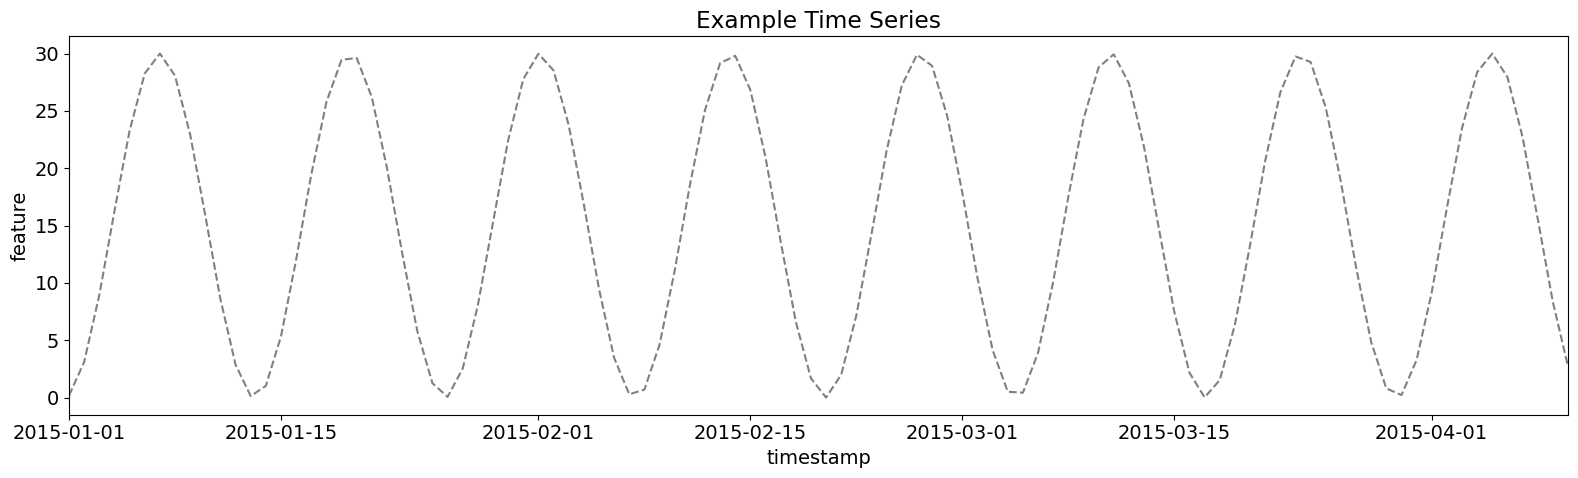

In [4]:
### Build fictional time series for experimenting ###
time        = np.arange(0, 100, 1)

df_sample = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods=len(time), freq='D'),
                   'feature' : 15*np.sin(0.5*time+30)+15})

df_sample.set_index('timestamp', inplace=True)

### Visualize time series ###
def plot_example_time_series(df, title = 'Example Time Series'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
    sns.lineplot(x=df.index, y=df.feature, color='grey', marker=None, linestyle='dashed')
    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
plot_example_time_series(df_sample)

In [5]:
time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                                   label_width = N_STEPS_OUT, 
                                                   shift       = 1, 
                                                   df          = df_sample, 
                                                   batch_size  = 32)

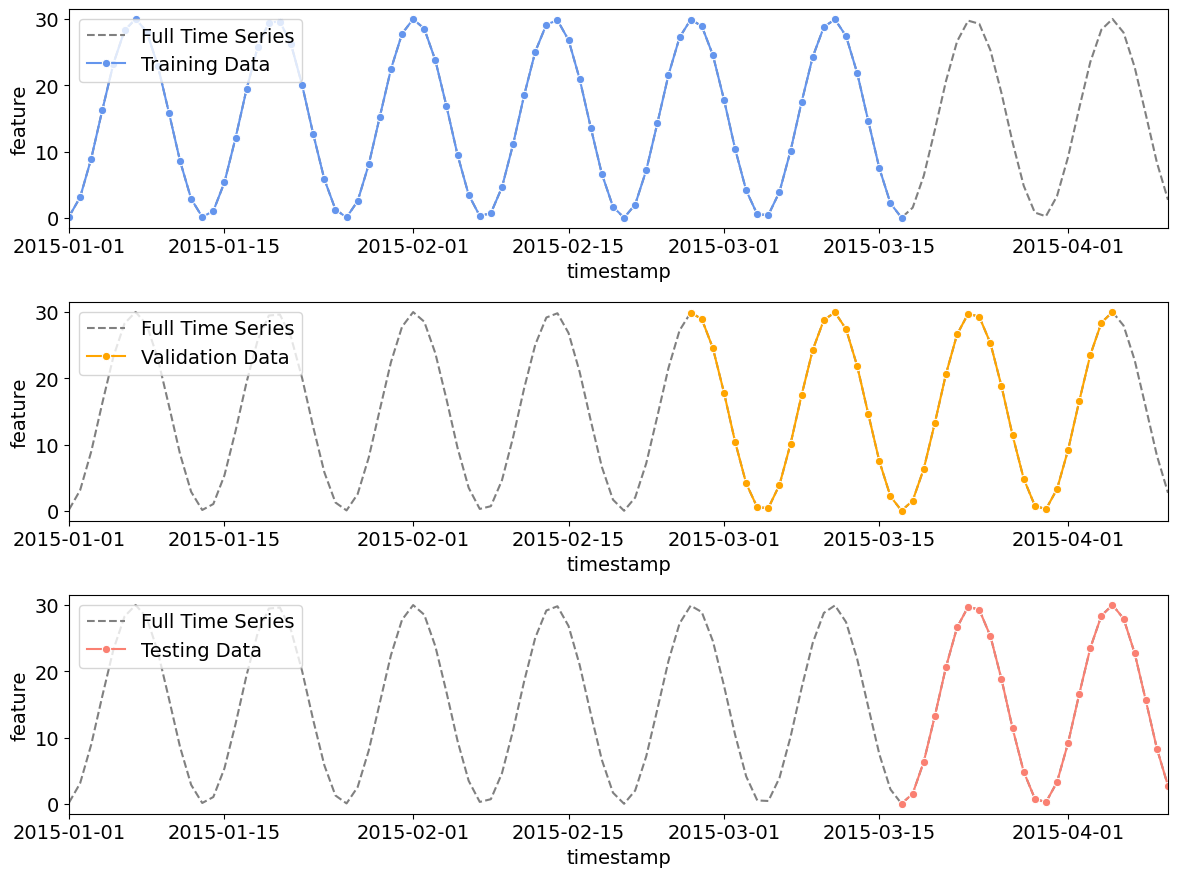

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 9))

for i in range(3):
    sns.lineplot(x=df_sample.index, y=df_sample.feature, color='grey', marker=None, linestyle='dashed', label='Full Time Series', ax=ax[i])

sns.lineplot(x=time_series_dataset.train_df.index, y=time_series_dataset.train_df.feature, color='cornflowerblue', marker='o', ax=ax[0], label='Training Data')
sns.lineplot(x=time_series_dataset.val_df.index, y=time_series_dataset.val_df.feature, color='orange', marker='o', ax=ax[1], label='Validation Data')
sns.lineplot(x=time_series_dataset.test_df.index, y=time_series_dataset.test_df.feature, color='salmon', marker='o', ax=ax[2], label = 'Testing Data')

for i in range(3):
    ax[i].set_xlim(df_sample.index[0], df_sample.index[-1])
    ax[i].legend(loc='upper left')
plt.tight_layout()
plt.show()

Notice, how the training and the validation dataframes and the validation and the testing dataframes overlap? They overlap by `N_STEPS_IN` samples. This means that, for example, the validation data takes the last `N_STEPS_IN` datapoints from the training data for the first input sequence and validates the model on yet unseen datapoints. This way, we don't lose valuable samples without causing data leakage. You can see that the last datapoints in the testing data don't overlap with the validation data by `N_STEPS_OUT`.

Below you can see a few example samples of X and y tuples, where X is of length `N_STEPS_IN` and y is of length `N_STEPS_OUT` with a sliding window and a shift of 1.

Inputs shape (batch, timesteps, features): (32, 20, 1)
Labels shape (batch, timesteps, features): (32, 5, 1)


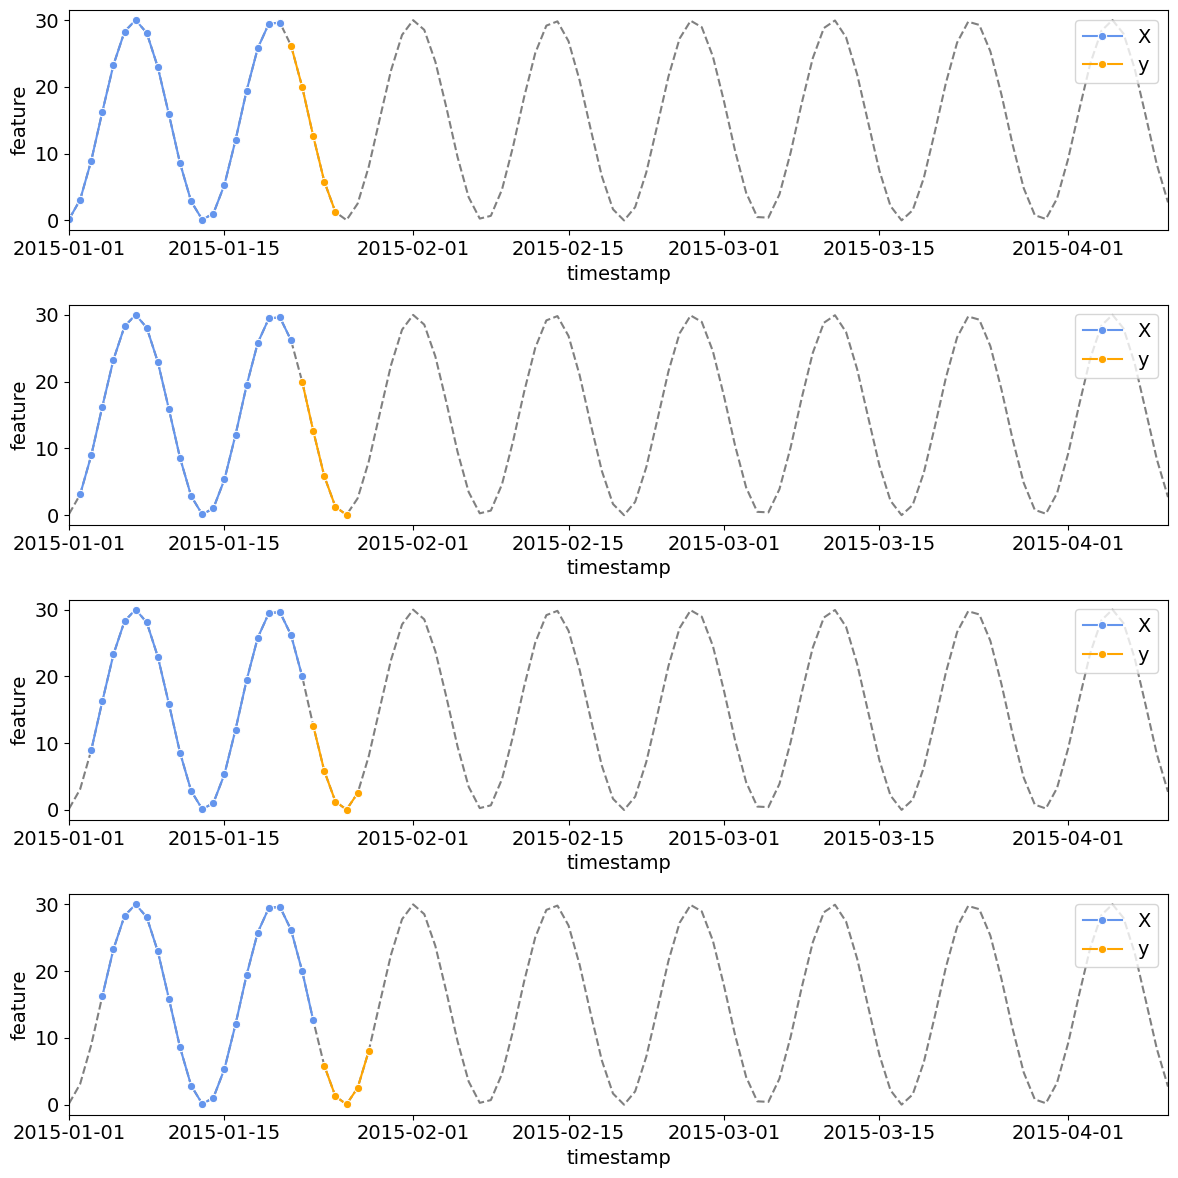

In [7]:
dataset = time_series_dataset.train

example_inputs = list(dataset.as_numpy_iterator())[0][0]
example_labels = list(dataset.as_numpy_iterator())[0][1]

print(f'Inputs shape (batch, timesteps, features): {example_inputs.shape}')
print(f'Labels shape (batch, timesteps, features): {example_labels.shape}')

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))

for i in range(4):
    X_test = example_inputs[i]
    y_test = example_labels[i]

    sns.lineplot(data = df_sample, x = 'timestamp', y = 'feature', linestyle='dashed', color = 'grey', ax = ax[i])
    sns.lineplot(x=df_sample.index[i:(i+N_STEPS_IN)], y=X_test.reshape(-1), label='X', color='cornflowerblue', marker='o',ax = ax[i])
    sns.lineplot(x=df_sample.index[(i+N_STEPS_IN):(i+N_STEPS_IN+N_STEPS_OUT)], y=y_test.reshape(-1), label='y', color='orange', marker='o',ax = ax[i])
    ax[i].set_xlim(df_sample.index[0], df_sample.index[-1])
    ax[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

# Baseline

Let's begin by creating a minimal reproducible baseline.

📌 **Fix Random Seed:** Before we begin, we need to fix the random seed to ensure reproducability.

In [8]:
# Seed value
SEED = 2022

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


## Model
We will start with a minimalistic model with one `LSTM` layer followed by a `Dense` layer.

The `LSTM` layer has the input shape of `(N_STEPS_IN, N_FEATURES)`. The value for `units` will be a function parameter for now, which we will discuss later on. In Keras the default activation function is `tanh`. However, we will be using `relu` for our examples. You can try out both and see which one leads to better results for your case.

The `Dense` layer has `N_STEPS_OUT` units. There will be [no activation function for the last layer since we have a regression problem](https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/).

📌 **Fix random seed for initializers:** Also, we need to ensure that the instances of our model are always initialized with the same parameter values to ensure reproducability and comparability.
For this purpose, we need to fix the random seed for the initializers `kernel_initializer` and `recurrent_initializer` .



In [9]:
def baseline_model(lstm_units): 
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed = SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)

    model = Sequential()
    model.add(LSTM(units                 = lstm_units, 
                   activation            = 'relu',
                   input_shape           = (N_STEPS_IN, N_FEATURES), 
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL))
    model.add(Dense(units              = N_STEPS_OUT,
                    kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
    return model

With the set parameters for `N_FEATURES`, `N_STEPS_IN`, and `N_STEPS_OUT`, the model looks as follows:

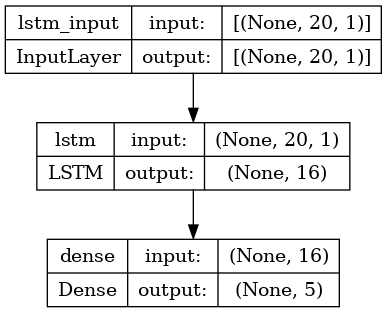

In [10]:
# Create model instance
model = baseline_model(16)

# Visualize model architecture
keras.utils.plot_model(model, show_shapes=True)

From the identical hash values across all initial model parameters we can see that fixing the seed for the initializers results in the same initial values for the model parameters when we create two instances of our model.

In [11]:
model_1 = baseline_model(16)
print(f"Hash for model {model_1._name}'s parameters: {hash(str(model_1.get_weights()))}")

model_2 = baseline_model(16)
print(f"Hash for model {model_2._name}'s parameters: {hash(str(model_2.get_weights()))}")

Hash for model sequential_1's parameters: -2817099831816420228
Hash for model sequential_2's parameters: -2817099831816420228


## Training

The following tips are some general tips that apply to any neural network:


📌 **Increase number of training data:** We will use fictional example time series with six years worth of data for this tutorial.

📌 **Increase number of epochs:** We will use 100 for this tutorial.

📌 **Decide on a batch size:** According to [this blog post](https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e), higher batch sizes lead to lower asymptotic test accuracy. For this tutorial, we will use 32. But you can try 64 or 128. 


In [12]:
time       = np.arange(0, 365*6, 1)
N_EPOCHS   = 100
BATCH_SIZE = 32

In [13]:
def plot_loss_and_predictions(y_pred, history, n_epochs, df):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    sns.lineplot(x=np.arange(1, len(history.history['loss'])+1, 1), y=history.history['loss'], label='Training Loss', color='cornflowerblue', marker='o', ax=ax[0])
    sns.lineplot(x=np.arange(1, len(history.history['loss'])+1, 1), y=history.history['val_loss'], label='Validation Loss', color='orange', marker='o', ax=ax[0])

    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_xlim([1, n_epochs])
    ax[0].legend(loc='upper right')
    
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                          label_width = N_STEPS_OUT, 
                                          shift       = 1, 
                                          df          = df, 
                                          batch_size  = BATCH_SIZE)
    X_test = list(time_series_dataset.test.as_numpy_iterator())[0][0]
    y_test = list(time_series_dataset.test.as_numpy_iterator())[0][1]
    
    sns.lineplot(data = df, x = 'timestamp', y = 'feature', linestyle='dashed', color='grey', ax = ax[1])
    sns.lineplot(x=df.index[-(N_STEPS_IN + N_STEPS_OUT):-(N_STEPS_OUT)], y=X_test.reshape(-1), label='X', color='cornflowerblue', marker='o', ax = ax[1])
    sns.lineplot(x=df.index[-N_STEPS_OUT:], y=y_test.reshape(-1), label='y', color='orange', marker='o', ax = ax[1])
    sns.lineplot(x=df.index[-N_STEPS_OUT:], y=y_pred.reshape(-1), label='y_pred', color='salmon', marker='o', ax = ax[1])
    ax[1].set_xlim(df.index[-int((N_STEPS_IN + N_STEPS_OUT)*1.2)], df.index[-1])
    all_datapoints = df.iloc[-int((N_STEPS_IN + N_STEPS_OUT)*1.2):].values
    ax[1].set_ylim([all_datapoints.min()-1, all_datapoints.max()+1])
    ax[1].set_title(f'Prediction on Test Dataset with MSE {mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1)):.5f}')
    plt.tight_layout()
    
    return ax

To evaluate the baselinem we will first compile our model with an Adam optimizer and an MSE loss. The dataframe of the sample time series is then processed into a time series dataset with our custom class `MultiStepTimeSeriesGenerator`. Then without any fancy cross validation strategy, the model is trained on the training dataset and validated on the validation dataset with an early stopping with a patience of 4 rounds. Finally, the model is tested on the testing dataset which contains one sample. In addition to the test score, a plot of the test prediction visualizes how well our model is able to make predictions.

In [14]:
def evaluate_baseline(model, df, n_epochs = N_EPOCHS, verbose = 0):
    # Compile model
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])
    
    # Create datasets from dataframe
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                              label_width = N_STEPS_OUT, 
                                              shift       = 1, 
                                              df          = df, 
                                              batch_size  = BATCH_SIZE)

    # Train model
    history = model.fit(time_series_dataset.train, 
                        validation_data = time_series_dataset.val,
                        epochs          = n_epochs,
                        batch_size      = BATCH_SIZE, 
                        verbose         = verbose, 
                        callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                           patience = 4),
                        shuffle         = False)

    # Make predictions on test set
    y_pred = model.predict(time_series_dataset.test, verbose=0)
    test_score = mean_squared_error(list(time_series_dataset.test.as_numpy_iterator())[0][1][0], y_pred.reshape(-1))
    test_score = np.round(test_score, 5)
    
    # Plot predictions
    ax = plot_loss_and_predictions(y_pred, history, n_epochs, df[['feature']])

    return test_score, ax

We will begin by trying to predict a constant time series. This should (hopefully) be an easy task.

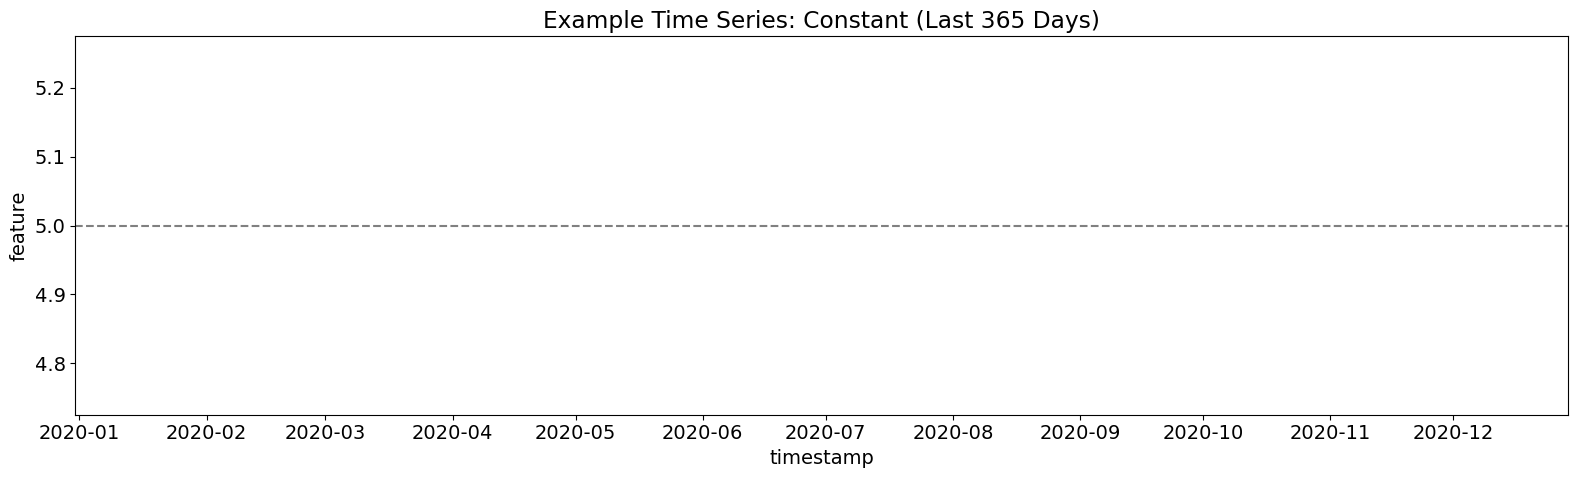

In [15]:
### Build fictional time series for experimenting ###

df_constant = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods = len(time), freq='D'),
                   'feature' : 5})

# Create timestamps and set as index
df_constant.set_index('timestamp', inplace=True)

plot_example_time_series(df_constant[-365:], title = 'Example Time Series: Constant (Last 365 Days)')

Let's train the model for a reduced amount of only 5 epochs to check if the baseline is reproducible.

Evaluate Baseline 1: 

Epoch 1/5
54/54 - 9s - loss: 21.3819 - mean_absolute_error: 4.5714 - val_loss: 15.0318 - val_mean_absolute_error: 3.6441 - 9s/epoch - 160ms/step
Epoch 2/5
54/54 - 2s - loss: 9.5794 - mean_absolute_error: 2.0929 - val_loss: 6.3383 - val_mean_absolute_error: 1.4511 - 2s/epoch - 40ms/step
Epoch 3/5
54/54 - 2s - loss: 4.7208 - mean_absolute_error: 1.2013 - val_loss: 3.3491 - val_mean_absolute_error: 1.0142 - 2s/epoch - 40ms/step
Epoch 4/5
54/54 - 2s - loss: 2.1945 - mean_absolute_error: 0.8558 - val_loss: 0.5047 - val_mean_absolute_error: 0.5094 - 2s/epoch - 40ms/step
Epoch 5/5
54/54 - 2s - loss: 0.0576 - mean_absolute_error: 0.1418 - val_loss: 9.4795e-04 - val_mean_absolute_error: 0.0276 - 2s/epoch - 43ms/step

Evaluate Baseline 2: 

Epoch 1/5
54/54 - 4s - loss: 21.3819 - mean_absolute_error: 4.5714 - val_loss: 15.0318 - val_mean_absolute_error: 3.6441 - 4s/epoch - 81ms/step
Epoch 2/5
54/54 - 3s - loss: 9.5794 - mean_absolute_error: 2.0929 - val_loss: 6.3383 - val_m

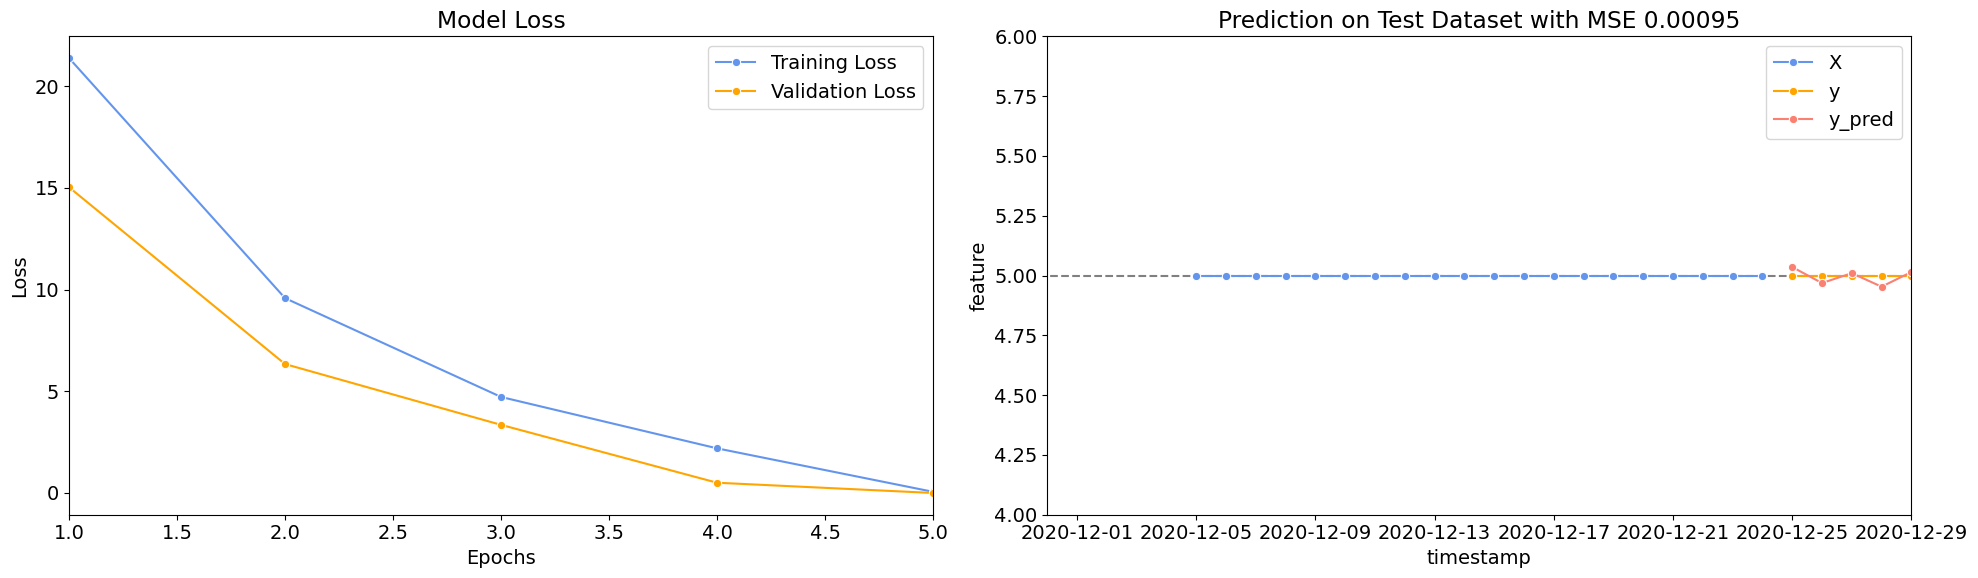

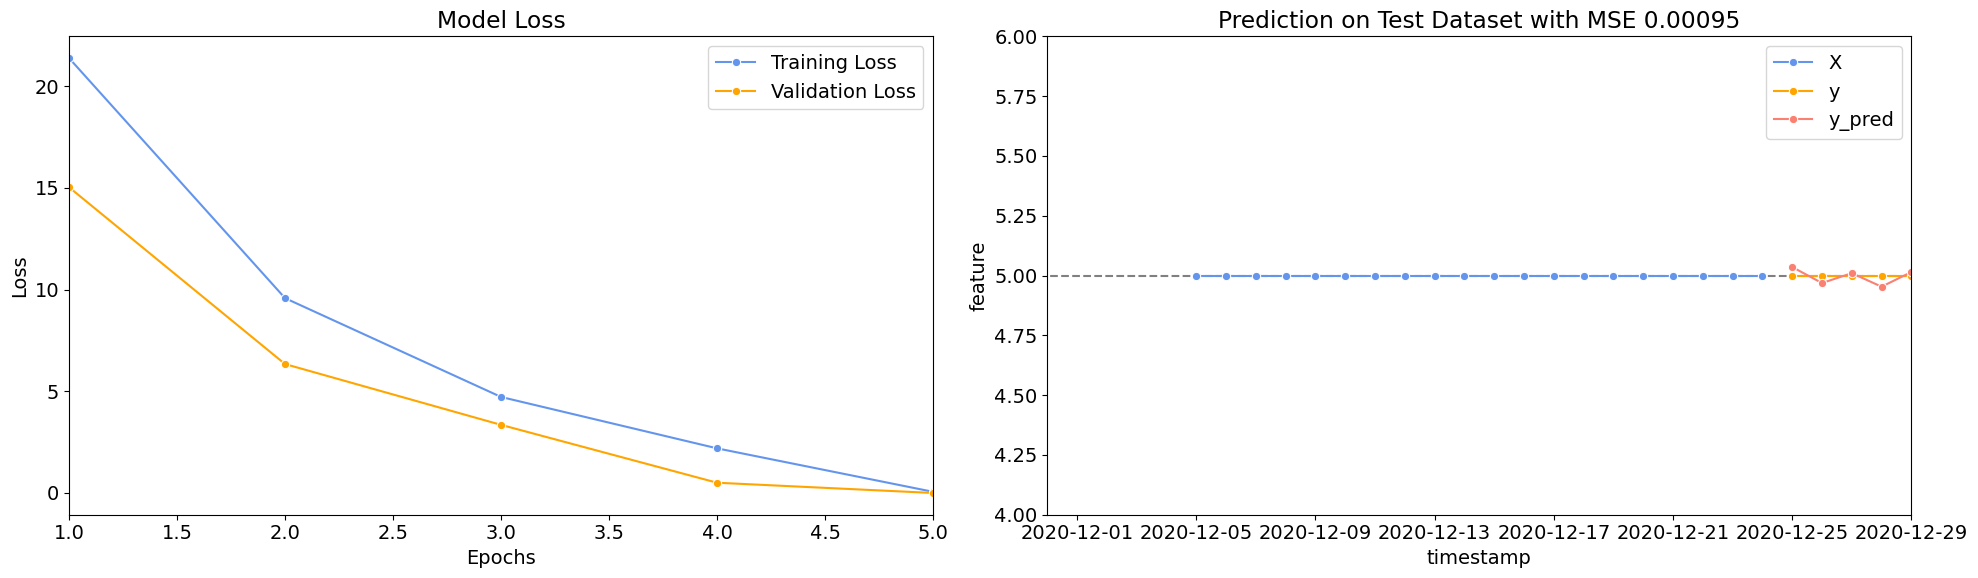

In [16]:
print('Evaluate Baseline 1: \n')
model_1 = baseline_model(16)
_, _ = evaluate_baseline(model_1, df_constant, n_epochs = 5, verbose = 2)

print('\nEvaluate Baseline 2: \n')
model_2 = baseline_model(16)
_, _ = evaluate_baseline(model_2, df_constant, n_epochs = 5, verbose = 2)

As you can see, the loss and mean absolute error are the same during training. Therefore, we can say that our **baseline is reproducible**! 

If we increase the number of epochs to `N_EPOCHS = 100`, we can also see that our baseline is able to predict our minimal example of the constant time series well.                     

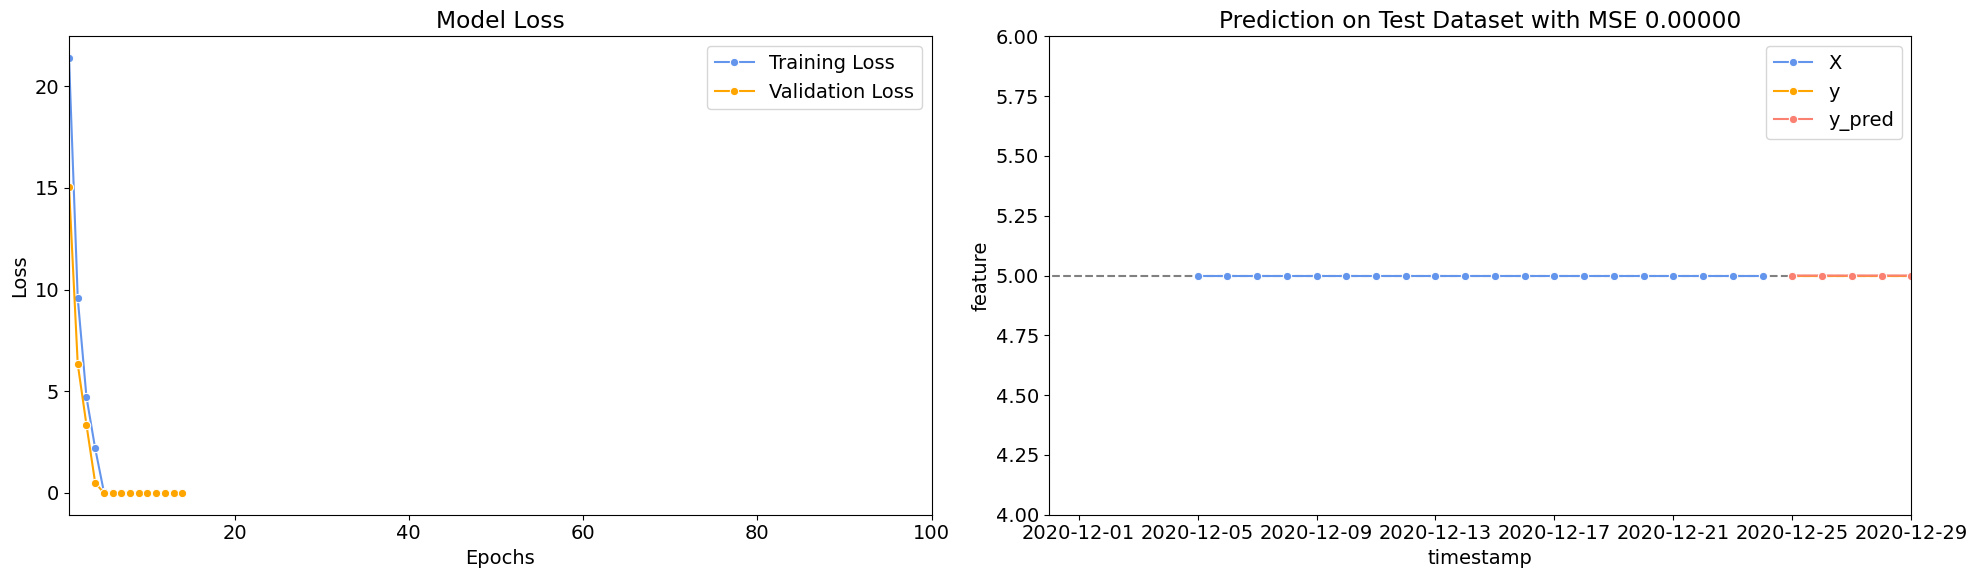

In [17]:
model_2 = baseline_model(16)
_, _ = evaluate_baseline(model_2, df_constant, n_epochs = N_EPOCHS)

# General Tips

## Differencing

While models like ARIMA require a time series to be stationary, according to [this discussion](https://datascience.stackexchange.com/questions/24800/time-series-prediction-using-lstms-importance-of-making-time-series-stationary), a time series does not necessarily have to be stationary when we use LSTMs.
However, according to [this blog post](https://www.freelancermap.com/blog/trend-prediction-with-lstm-rnns-using-keras-tensorflow-in-3-steps/) LSTMs are only capable to predict unseen data well within the range of the training data and they have difficulties predicting data outside the boundaries of training data.

Let's have a look at a time series with linear trend.

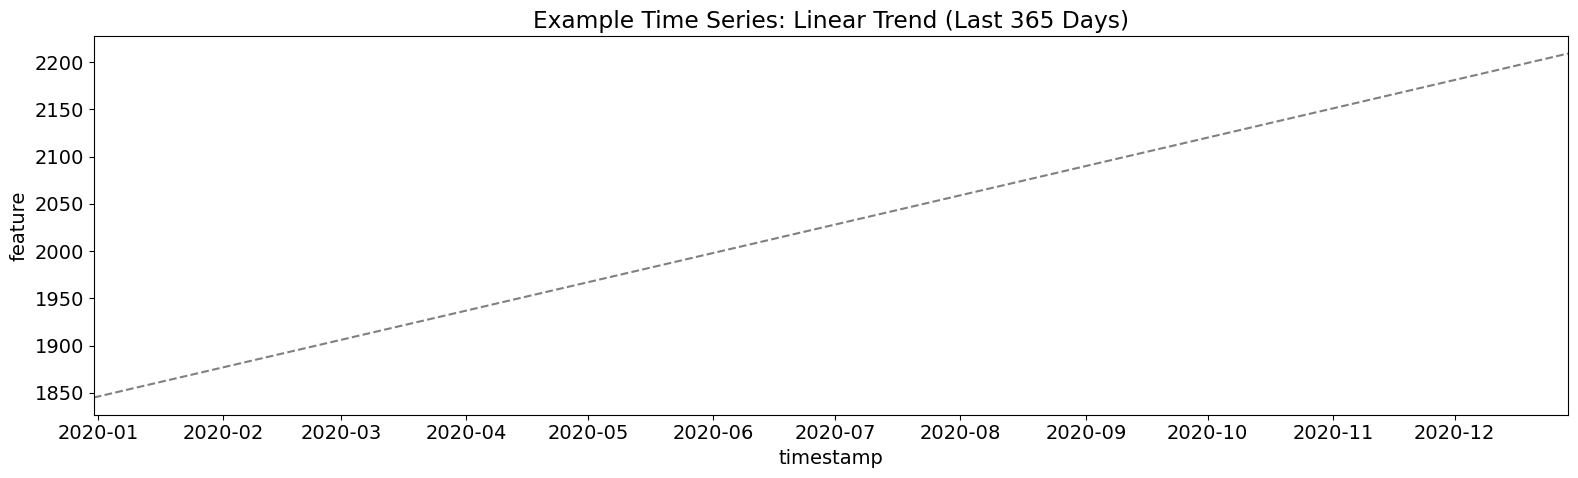

In [18]:
### Build fictional time series for experimenting ###
df_linear = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods = len(time), freq='D'),
                   'feature' : (1*time)+20,
                  })

# Create timestamps and set as index
df_linear.set_index('timestamp', inplace=True)

plot_example_time_series(df_linear[-365:], title = 'Example Time Series: Linear Trend (Last 365 Days)')

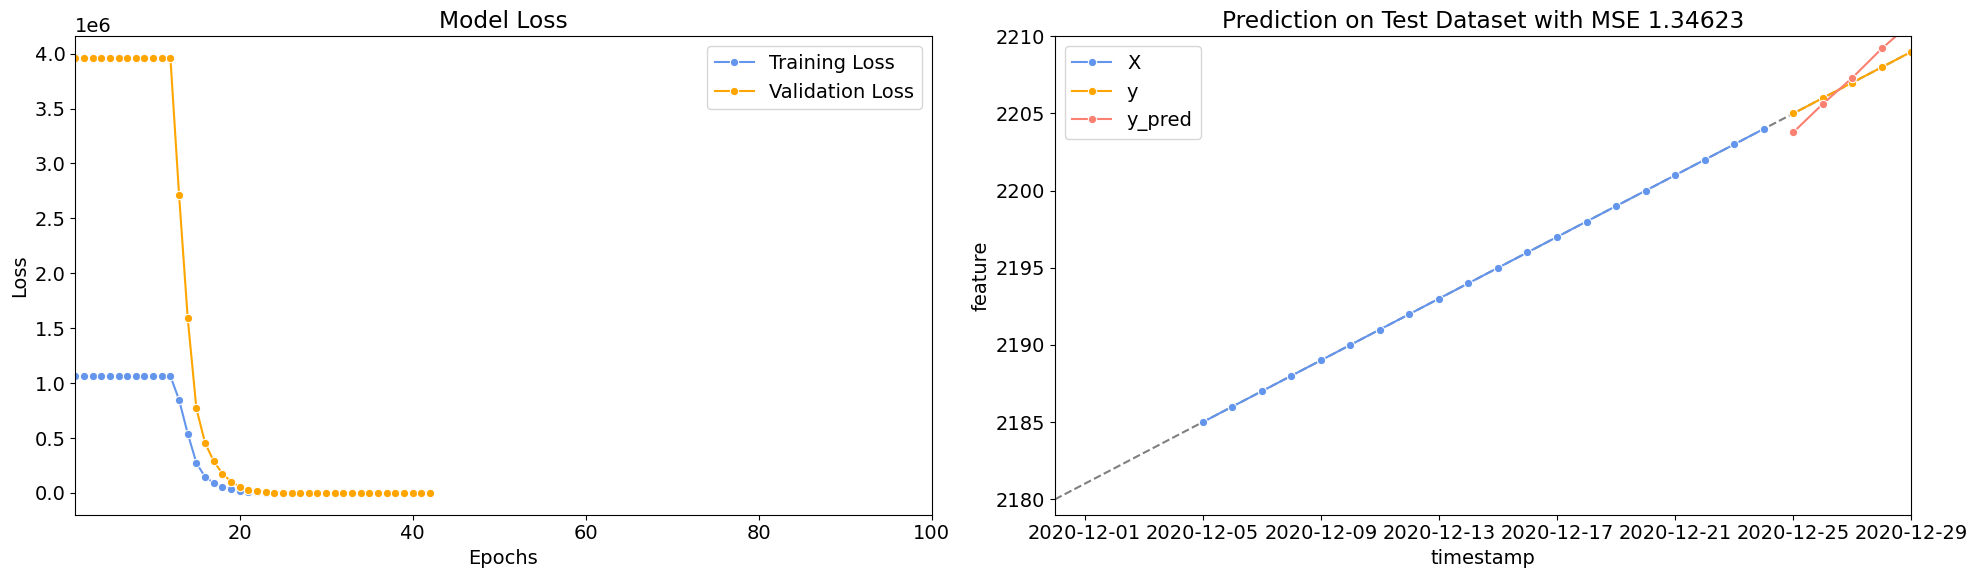

In [19]:
model = baseline_model(16)
_, _ = evaluate_baseline(model, df_linear)

As expected, our very minimal baseline from the previous example does not result in any good predictions. 

📌 **Use Differencing to Remove Trend:** In this case, we need to use differencing to remove the trend from the time series. For this we can use the function `diff()`.

In [20]:
df_differenced = df_linear.diff()[1:]

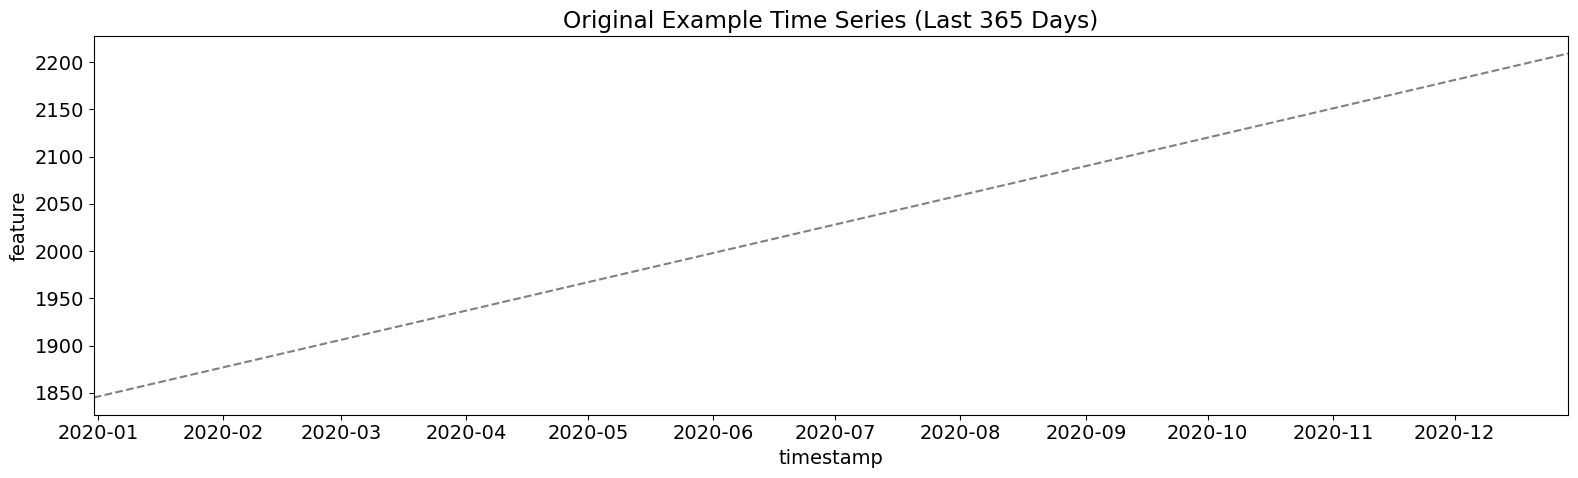

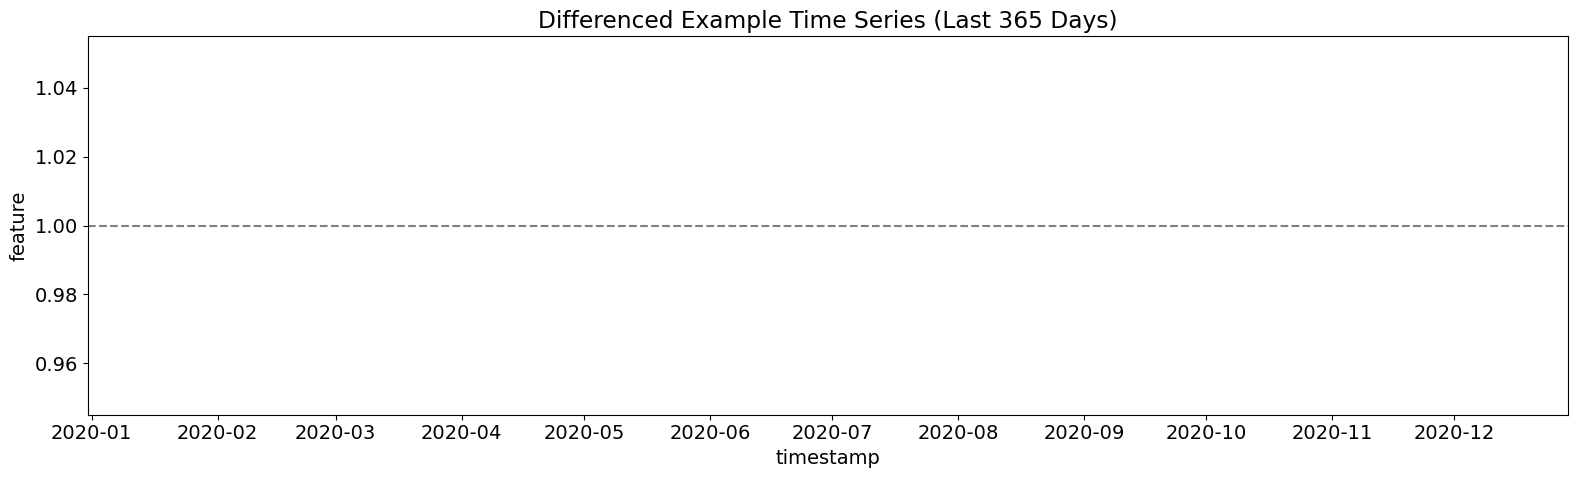

In [21]:
plot_example_time_series(df_linear[-365:], title = 'Original Example Time Series (Last 365 Days)')

plot_example_time_series(df_differenced[-365:], title = 'Differenced Example Time Series (Last 365 Days)')

As you can see, we now have a similar time series problem as our first example with constant characteristics. This problem can be easily modeled with our minimal baseline as previously shown.

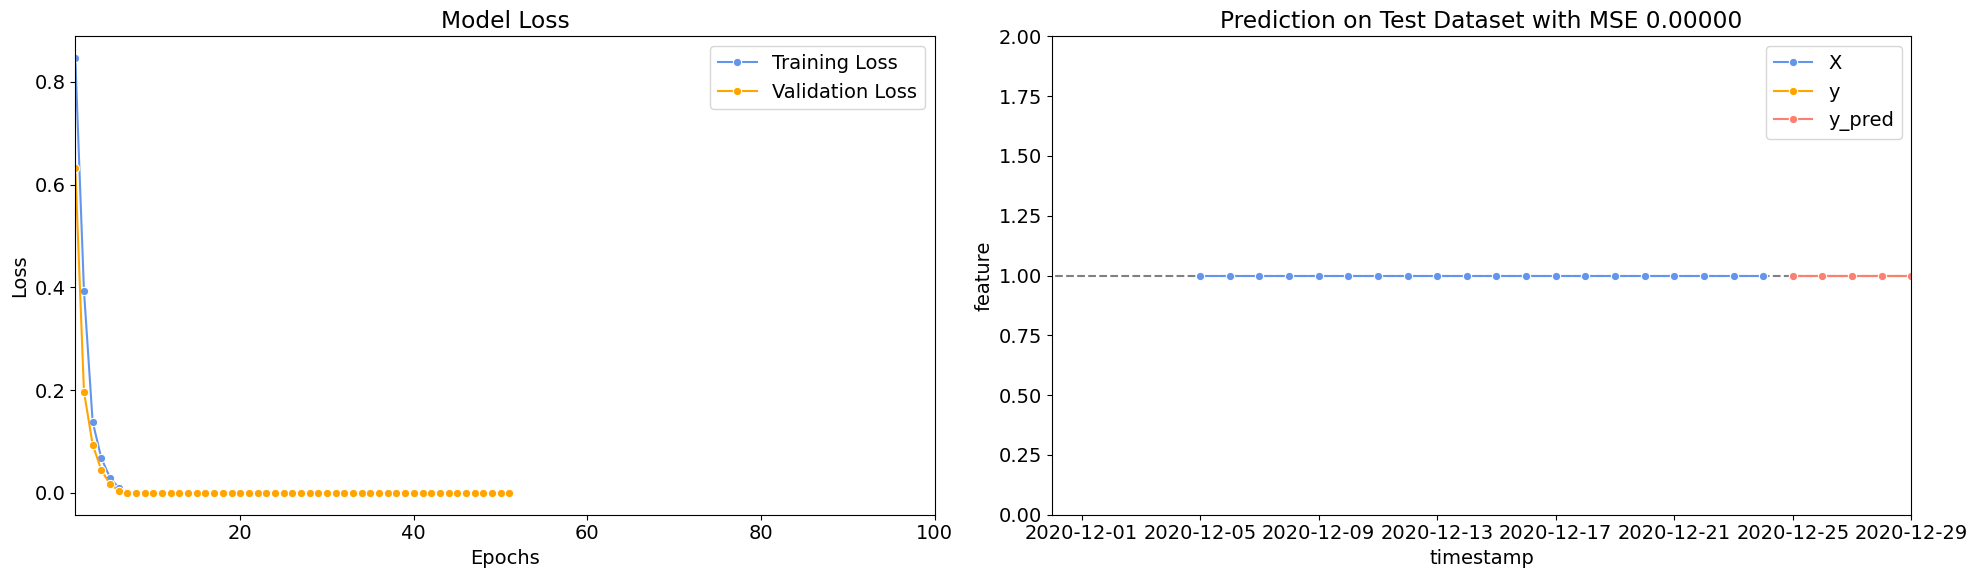

In [22]:
model = baseline_model(16)
_, _ = evaluate_baseline(model, df_differenced)

After using the differenced time series for modeling and predicting, you can use the function `.cumsum()` to reverse the differencing. From the reverted plot you can see that our model is now able to make much better predictions with the differenced time series.

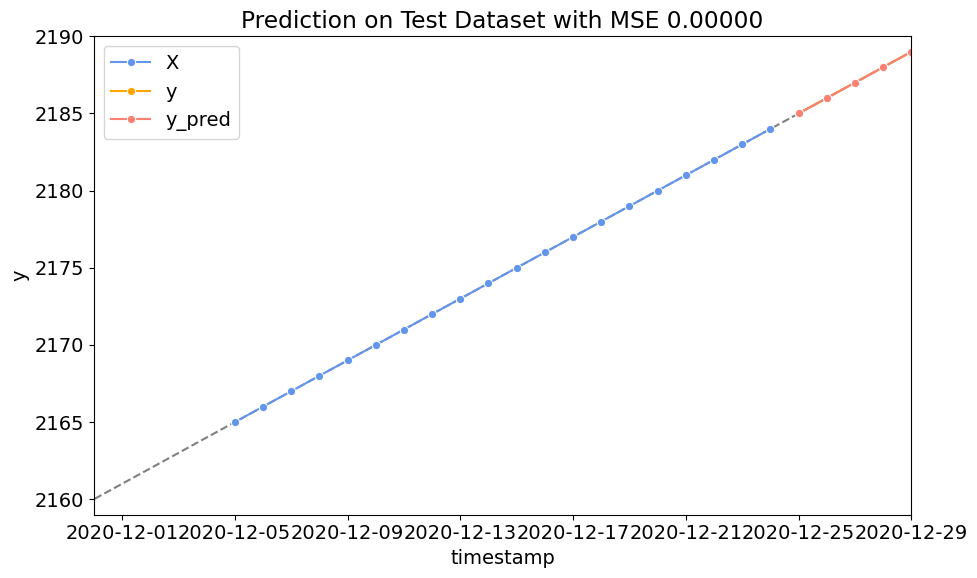

In [23]:
# Create datasets from dataframe
time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                          label_width = N_STEPS_OUT, 
                                          shift       = 1, 
                                          df          = df_differenced, 
                                          batch_size  = BATCH_SIZE)


# Make predictions on test set
y_pred = model.predict(time_series_dataset.test, verbose=0)
df_differenced.columns = ['y_diff']
df_differenced['y_diff_pred'] = df_differenced['y_diff']
df_differenced['y_diff_pred'].to_numpy()[-5:] = y_pred
df_differenced['y'] = df_differenced['y_diff'].cumsum()
df_differenced['y_pred'] = df_differenced['y_diff_pred'].cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
df_linear = df_differenced.copy()
sns.lineplot(data = df_linear, x = 'timestamp', y = 'y', linestyle='dashed', color='grey')
sns.lineplot(x=df_linear.index[-(N_STEPS_IN + N_STEPS_OUT):-(N_STEPS_OUT)], y=df_linear.iloc[-(N_STEPS_IN + N_STEPS_OUT):-(N_STEPS_OUT)]['y'], label='X', color='cornflowerblue', marker='o')
sns.lineplot(x=df_linear.index[-N_STEPS_OUT:], y=df_linear.iloc[-N_STEPS_OUT:]['y'], label='y', color='orange', marker='o')
sns.lineplot(x=df_linear.index[-N_STEPS_OUT:], y=df_linear.iloc[-N_STEPS_OUT:]['y_pred'], label='y_pred', color='salmon', marker='o')
ax.set_xlim(df_linear.index[-int((N_STEPS_IN + N_STEPS_OUT)*1.2)], df_linear.index[-1])
all_datapoints = df_linear.iloc[-int((N_STEPS_IN + N_STEPS_OUT)*1.2):]['y'].values
ax.set_ylim([all_datapoints.min()-1, all_datapoints.max()+1])
ax.set_title(f'Prediction on Test Dataset with MSE {mean_squared_error(df_linear.iloc[-N_STEPS_OUT:].y.values, df_linear.iloc[-N_STEPS_OUT:].y_pred.values):.5f}')
plt.tight_layout()
plt.show()

## Feature Transformations
Let's increase the complexity of the time series by trying to predict a time series with seasonality. 

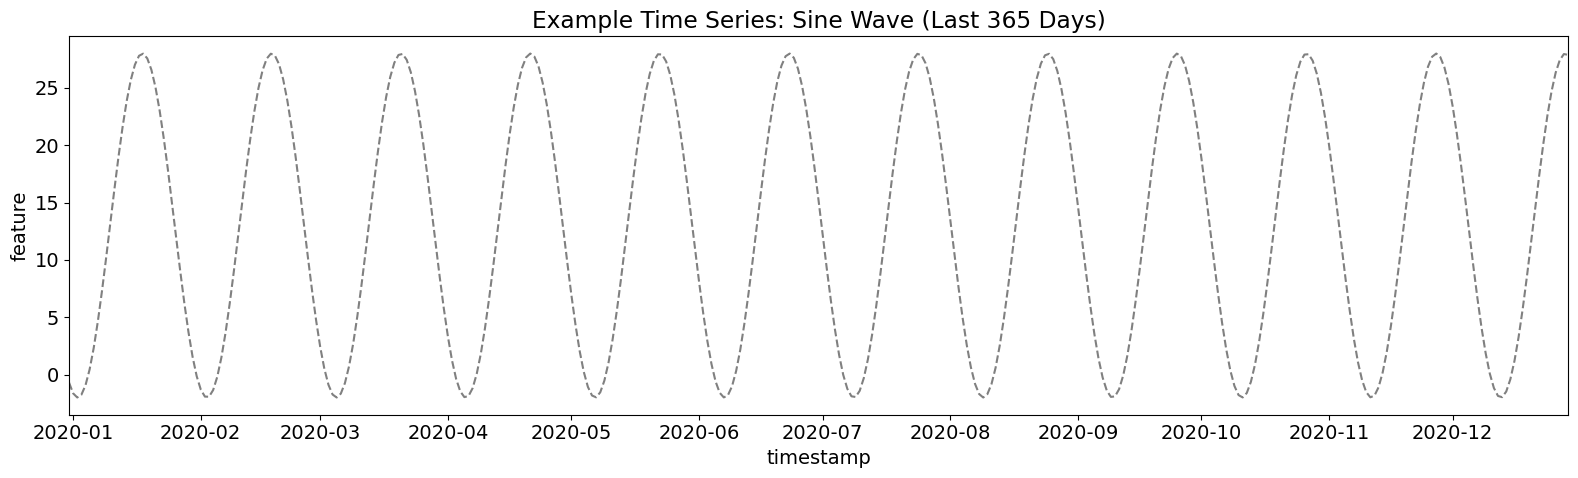

In [24]:
### Build fictional time series for experimenting ###
df_sine = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods = len(time), freq='D'),
                   'feature' : 15*np.sin(0.2*time+10)+13,
                  })

# Create timestamps and set as index
df_sine.set_index('timestamp', inplace=True)

plot_example_time_series(df_sine[-365:], title = 'Example Time Series: Sine Wave (Last 365 Days)')

First, we will use our previous minimal baseline setup and see what the predictive capabilities of this model are.

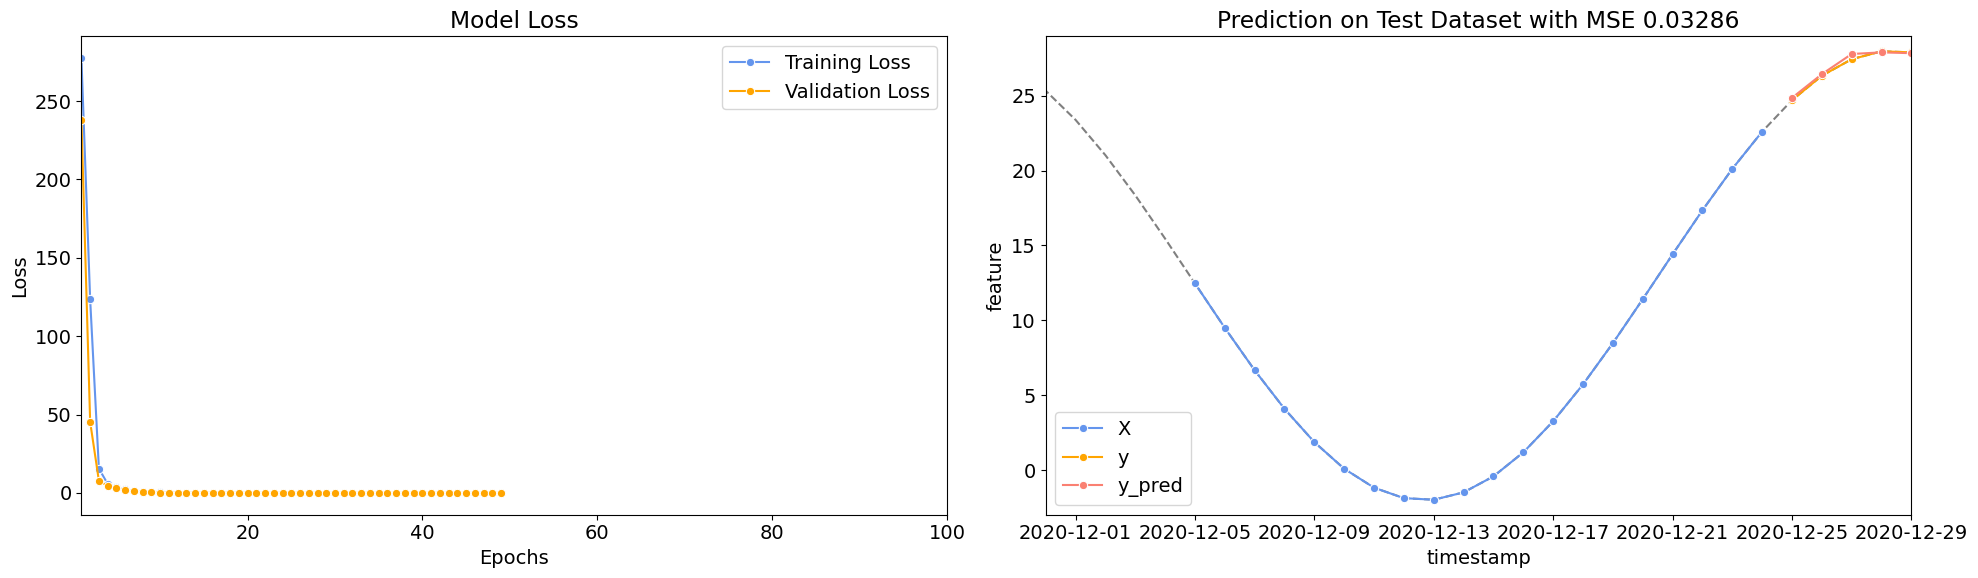

In [25]:
model = baseline_model(16)
_, _ = evaluate_baseline(model, df_sine)

We can see that the model already has quite good predictive capabilities. However, let's see if we can improve the test score.

📌 **Apply Feature Transformations: Normalization or Standardization**

As with other deep learning problems, we can help the neural network learn more rapidly by normalizing the features between 0 and 1 or standardizing the features. However, there seems to be no rule when to use which feature transformation similarly to the "No Free Lunch Theorem". That means, to try out both and see which one performs better.

We will use the `MinMaxScaler` from the `sklearn.preprocessing` library to normalize the data and we will use the `StandardScaler` from the `sklearn.preprocessing` library to standardize the data.

In [26]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df_sine['feature_normalized'] = MinMaxScaler().fit_transform(df_sine[['feature']])
df_sine['feature_standardized'] = StandardScaler().fit_transform(df_sine[['feature']])

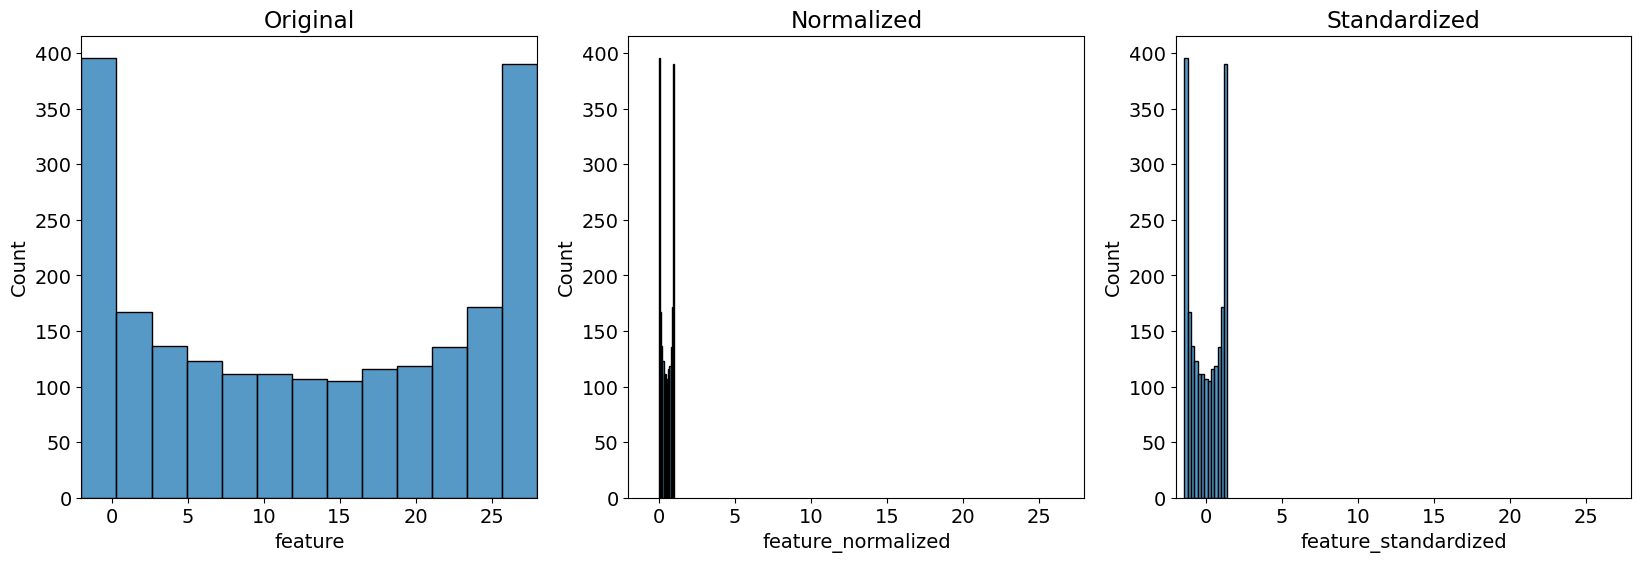

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.histplot(x=df_sine['feature'], ax=ax[0])
ax[0].set_title('Original')
sns.histplot(x=df_sine['feature_normalized'], ax=ax[1])
ax[1].set_title('Normalized')
sns.histplot(x=df_sine['feature_standardized'], ax=ax[2])
ax[2].set_title('Standardized')

for i in range(3):
    ax[i].set_xlim([-2,28])
plt.show()

df_sine.drop(['feature_normalized', 'feature_standardized'], axis=1, inplace=True)

We will now modify the function `evaluate_baseline()` in a way that the dataframe of the time series is transformed before it is fed into the `MultiStepTimeSeriesGenerator`. Furthermore, we will inverse transform the predictions for the calculation of the test score. 

In [28]:
def standardize_and_evaluate_baseline(model, df, n_epochs = N_EPOCHS, verbose = 0):
    # Compile model
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])
    
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled['feature'] = scaler.fit_transform(df_scaled[['feature']])
    ##########################################################################
    
    # Create datasets from dataframe
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                              label_width = N_STEPS_OUT, 
                                              shift       = 1, 
                                              df          = df_scaled, 
                                              batch_size  = BATCH_SIZE)

    # Train model
    history = model.fit(time_series_dataset.train, 
                        validation_data = time_series_dataset.val,
                        epochs          = n_epochs,
                        batch_size      = BATCH_SIZE, 
                        verbose         = verbose, 
                        callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                           patience = 4),
                        shuffle         = False)

    # Make predictions on test set
    y_pred = model.predict(time_series_dataset.test, verbose=0)
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
    y_pred = scaler.inverse_transform(y_pred)
    test_score = mean_squared_error(scaler.inverse_transform(list(time_series_dataset.test.as_numpy_iterator())[0][1][0]), y_pred.reshape(-1))
    ##########################################################################
    test_score = np.round(test_score, 5)
    
    # Plot predictions
    ax = plot_loss_and_predictions(y_pred, history, n_epochs, df[['feature']])

    return test_score, ax

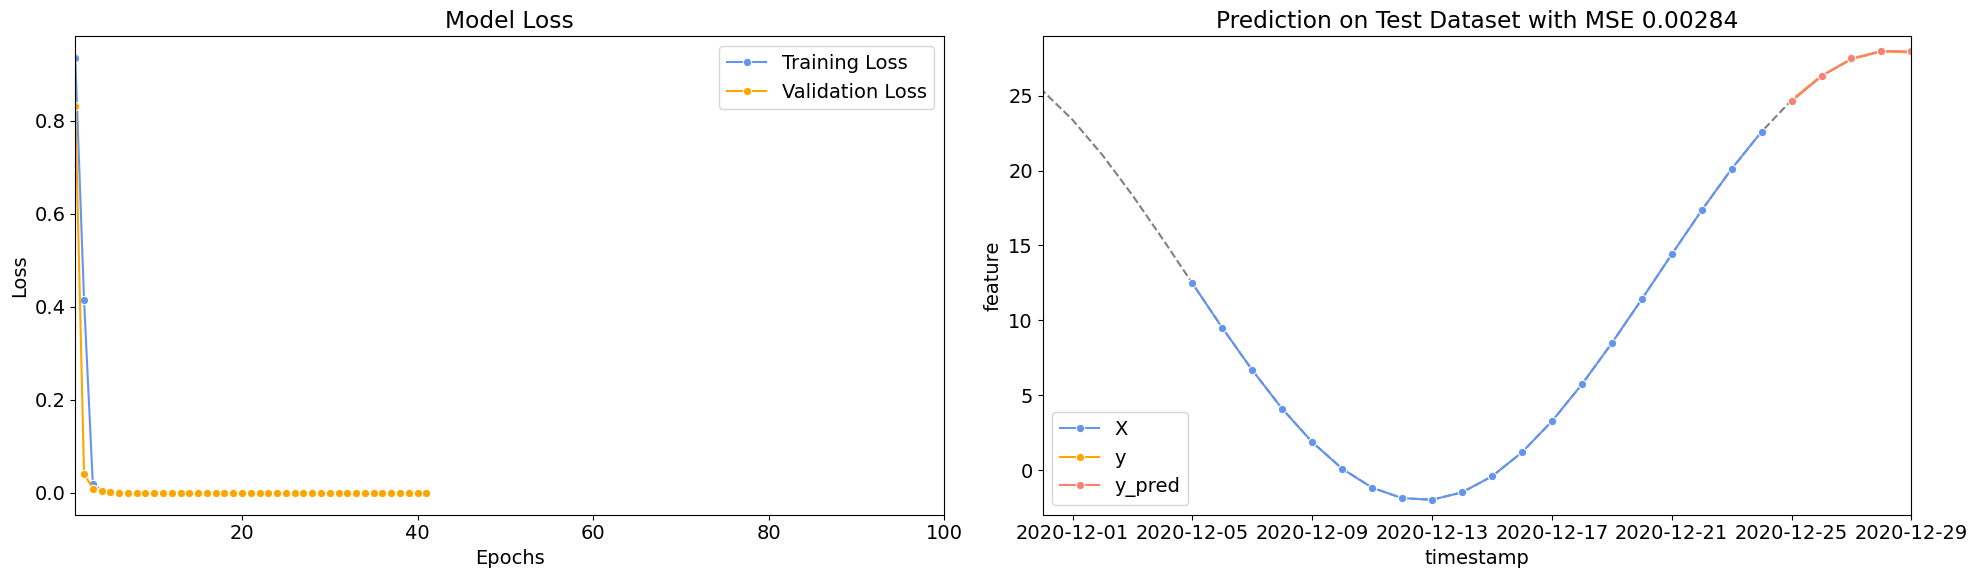

In [29]:
model = baseline_model(16)
_, _ = standardize_and_evaluate_baseline(model, df_sine)

In [30]:
def normalize_and_evaluate_baseline(model, df, n_epochs = N_EPOCHS, verbose = 0):
    # Compile model
    model.compile(loss      = tf.losses.MeanSquaredError(),
                  optimizer = tf.optimizers.Adam(),
                  metrics   = [tf.metrics.MeanAbsoluteError()])
    
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled['feature'] = scaler.fit_transform(df_scaled[['feature']])
    ##########################################################################

    # Create datasets from dataframe
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = N_STEPS_IN, 
                                              label_width = N_STEPS_OUT, 
                                              shift       = 1, 
                                              df          = df_scaled, 
                                              batch_size  = BATCH_SIZE)

    # Train model
    history = model.fit(time_series_dataset.train, 
                        validation_data = time_series_dataset.val,
                        epochs          = n_epochs,
                        batch_size      = BATCH_SIZE, 
                        verbose         = verbose, 
                        callbacks       = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                                          patience = 4),
                        shuffle         = False)


    # Make predictions on test set
    y_pred = model.predict(time_series_dataset.test, verbose=0)
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
    y_pred = scaler.inverse_transform(y_pred)
    test_score = mean_squared_error(scaler.inverse_transform(list(time_series_dataset.test.as_numpy_iterator())[0][1][0]), y_pred.reshape(-1))
    ##########################################################################
    test_score = np.round(test_score, 5)
    
    # Plot predictions
    ax = plot_loss_and_predictions(y_pred, history, n_epochs, df[['feature']])

    return test_score, ax

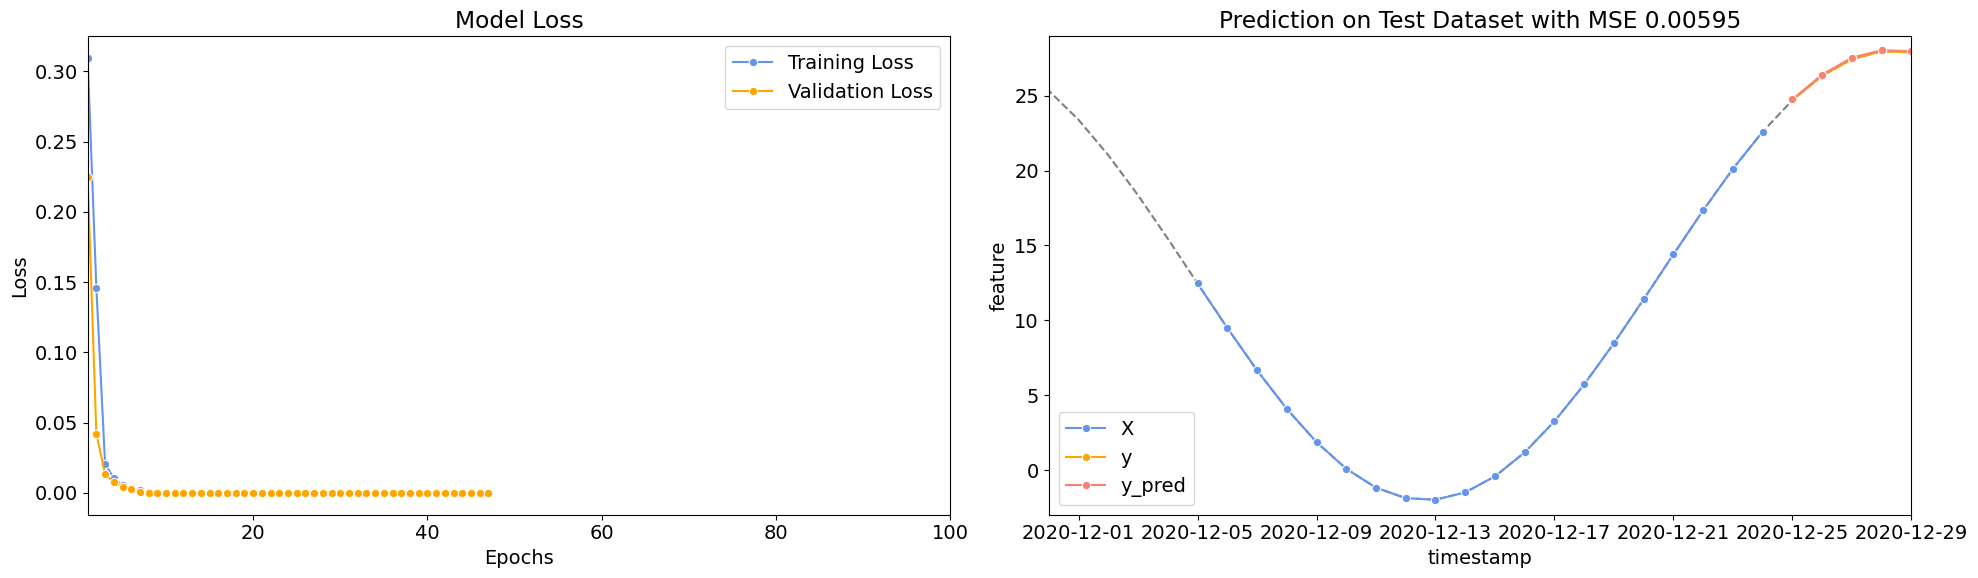

In [31]:
model = baseline_model(16)
_, _ = normalize_and_evaluate_baseline(model, df_sine)

As you can see, both feature transformations improve the performance.

# Model Architecture
Let's try another seasonal time series but with different characteristics.

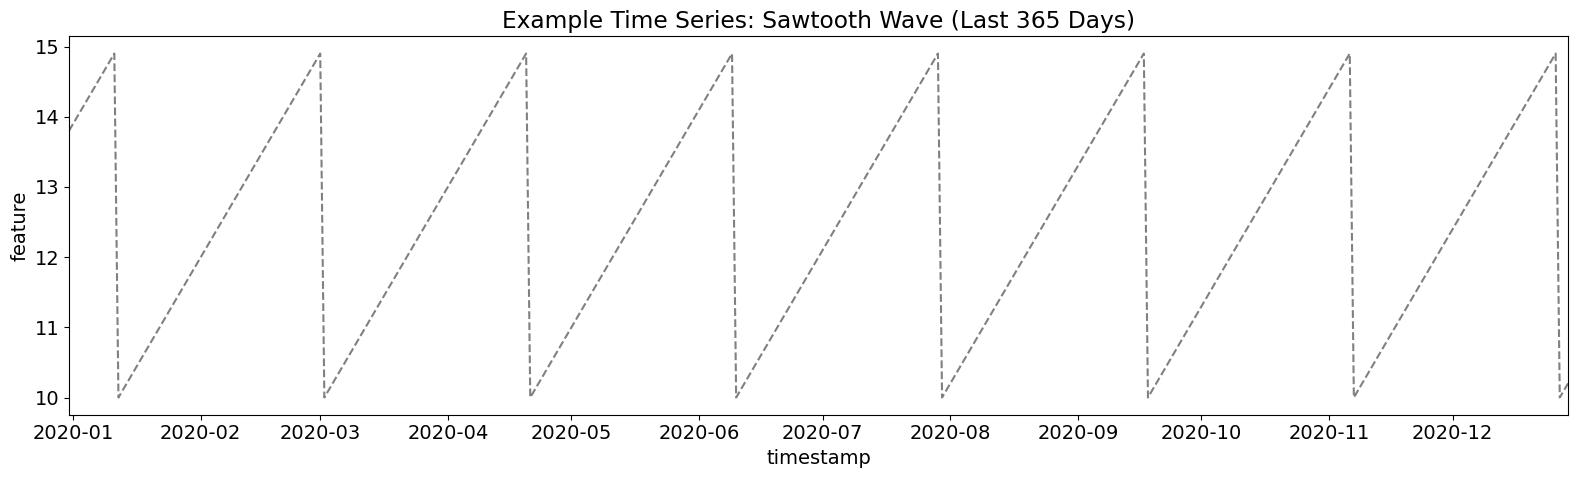

In [32]:
### Build fictional time series for experimenting ###
df_modulo = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods = len(time), freq='D'),
                   'feature' : (( time + 13 ) % 50) * 0.1 + 10
                  })

# Create timestamps and set as index
df_modulo.set_index('timestamp', inplace=True)

plot_example_time_series(df_modulo[-365:], title = 'Example Time Series: Sawtooth Wave (Last 365 Days)')

We will run our baseline model on this modulo time series to get a benchmark.

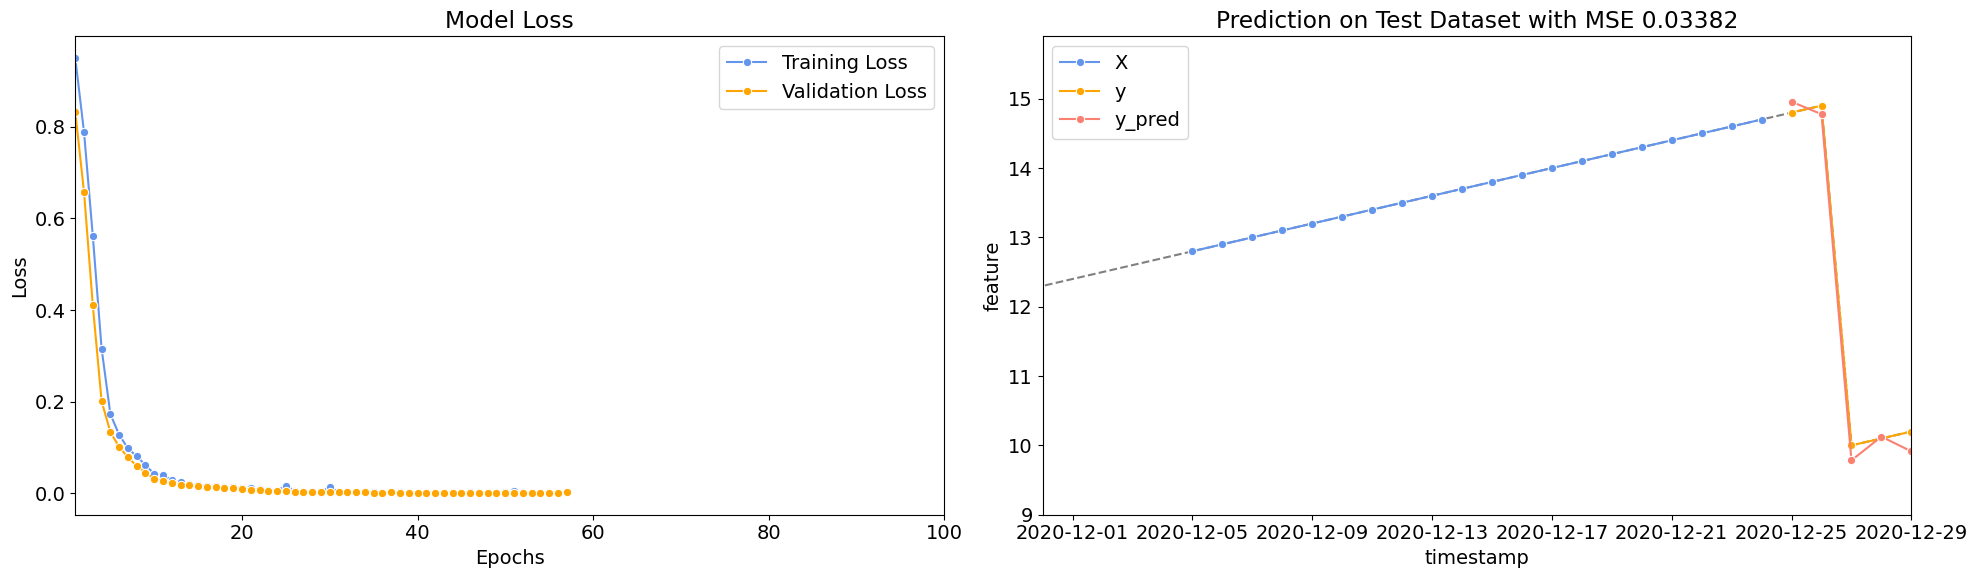

In [33]:
model = baseline_model(16)
_, _ = standardize_and_evaluate_baseline(model, df_modulo)

📌 **Increase LSTM parameter `units`:** Another idea to increase the accuracy, is to increase the `units` parameter for the LSTM layer.

However, increasing the amount of units can on the one hand lead to overfitting and on the other hand decrease performance as you can see below. Although the test score starts to improve with inreasing number of `units`, after it reaches its global minimum at 128, the test score starts to increase again.
Since the amount of model parameters increase exponentially with increasing `units`, you should evaluate which value is the best trade-off between test score and amount of model parameters.

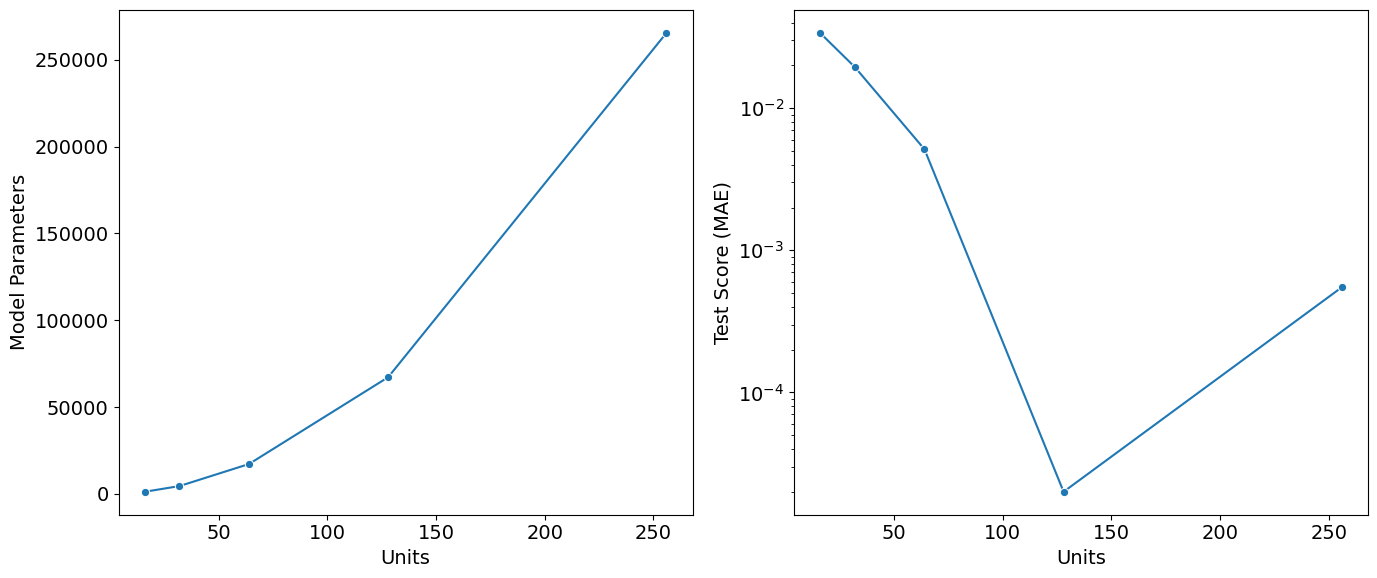

In [34]:
model_params = []
test_score = []
units = [16, 32, 64, 128, 256]
for n in units:
    model = baseline_model(n)
    metric, _ = standardize_and_evaluate_baseline(model, df_modulo)
    model_params.append(model.count_params())
    test_score.append(metric)
    plt.close()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.lineplot(x=units, y=model_params, marker = 'o', ax=ax[0])
ax[0].set_xlabel('Units')
ax[0].set_ylabel('Model Parameters')

sns.lineplot(x=units, y=test_score, marker = 'o', ax=ax[1])
ax[1].set_xlabel('Units')
ax[1].set_ylabel('Test Score (MAE)')
ax[1].set_yscale('log')
plt.tight_layout()
plt.show()

If we quadruple the amount of `units`, the test score improves.

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 128)               66560     
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 67,205
Trainable params: 67,205
Non-trainable params: 0
_________________________________________________________________


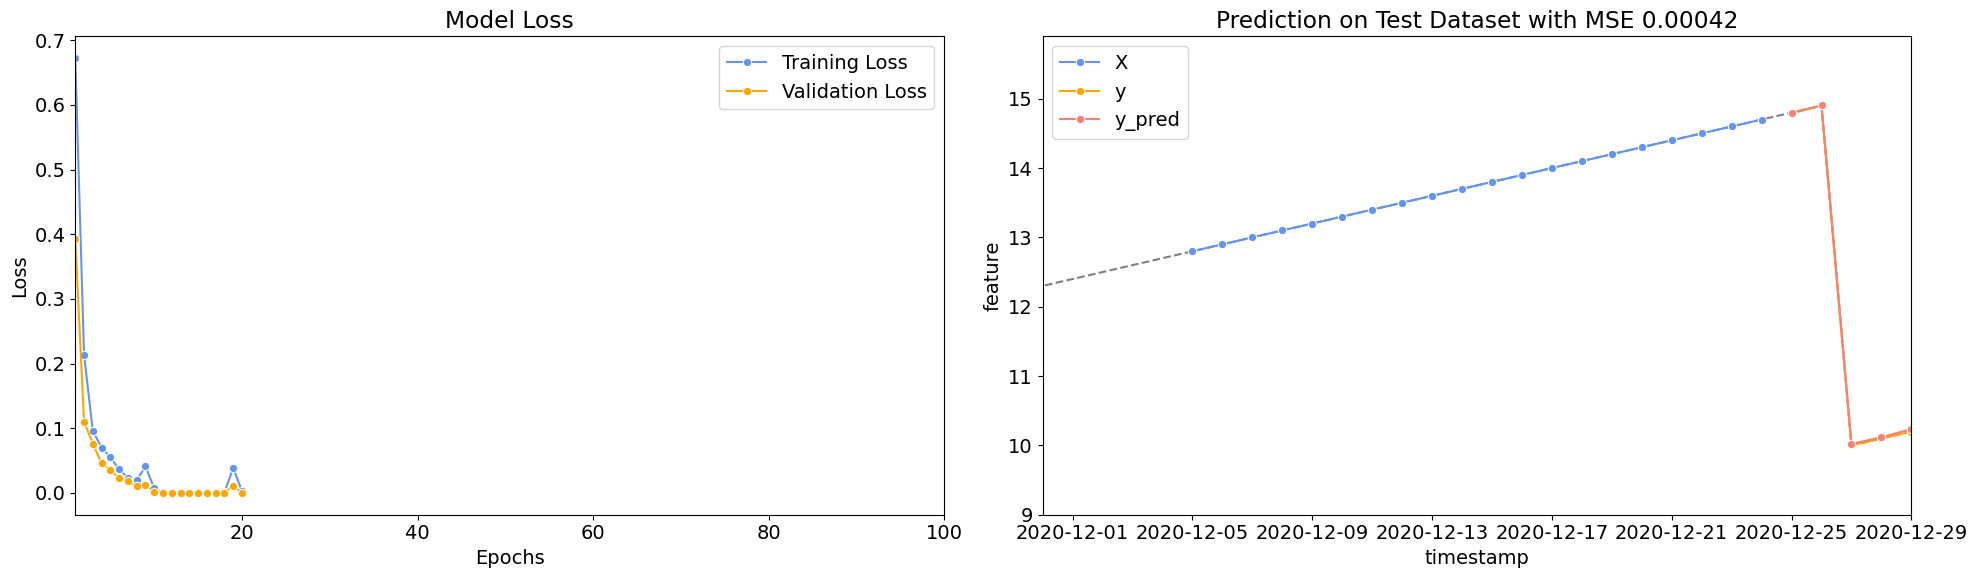

In [35]:
model = baseline_model(128)
model.summary()
_, _ = standardize_and_evaluate_baseline(model, df_modulo)

However, with the above approach, we end up with 67,205 parameters.

📌 **Increase depth of neural network by stacking LSTM layers:** Another idea for improving the performance can be to increase the depth of the neural network by stacking multiple LSTM layers.

Until now, we had a model with a "many to one" characteristic. However, if we want to increase the depth of the neural network, we need to stack LSTM layers. In this case, we need a "many to many" characteristic. 

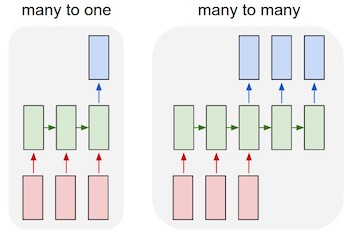

Image Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

This can be achieved by setting the parameter option `return_sequences = True`.

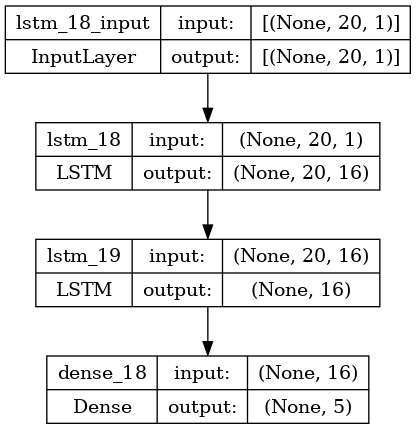

In [36]:
def model_with_stacked_lstm(lstm_units): 
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed = SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)

    model = Sequential()
    
    model.add(LSTM(units                 = lstm_units, 
                   input_shape           = (N_STEPS_IN, N_FEATURES), 
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL,
    ##########################################################################
    # NEWLY ADDED
    # https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras
    ##########################################################################
                   return_sequences      = True)) 
    model.add(LSTM(units                 = lstm_units, 
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL))
    ##########################################################################
    
    model.add(Dense(units              = N_STEPS_OUT,
                    kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
    return model

# Create model instance
model = model_with_stacked_lstm(16)

# Visualize model architecture
display(keras.utils.plot_model(model, show_shapes=True))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 20, 32)            4352      
                                                                 
 lstm_21 (LSTM)              (None, 32)                8320      
                                                                 
 dense_19 (Dense)            (None, 5)                 165       
                                                                 
Total params: 12,837
Trainable params: 12,837
Non-trainable params: 0
_________________________________________________________________


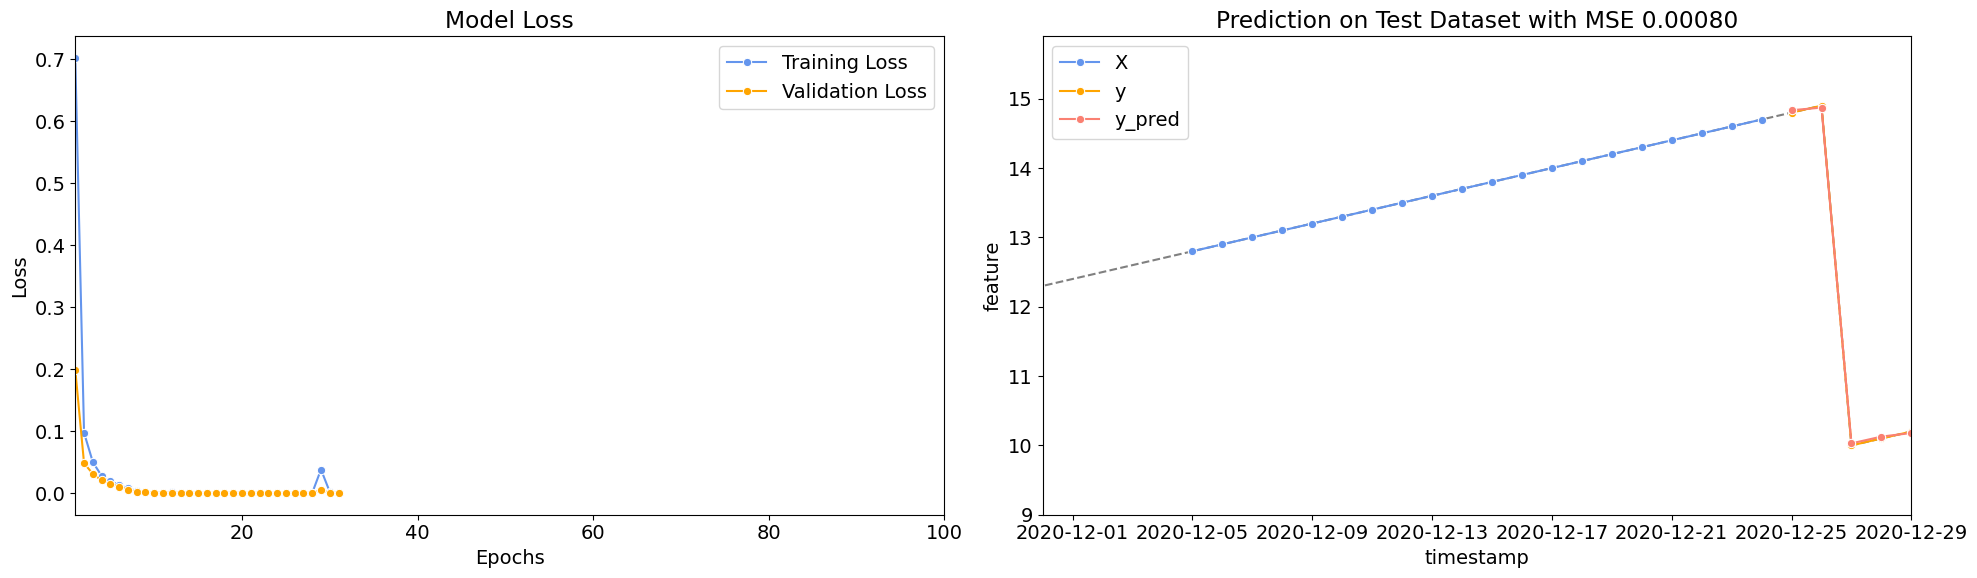

In [37]:
model = model_with_stacked_lstm(32)
model.summary()
_, _ = standardize_and_evaluate_baseline(model, df_modulo)

We can reach similar results with roughly 13,000 model parameters instead of roughly 67,000 model parameters if we stack two LSTMs with 32 units instead of one wide LSTM with 128 units.

# Regularization
To test the regularization capabilities of our model, we will create a new time series based on the sine wave with added noise.

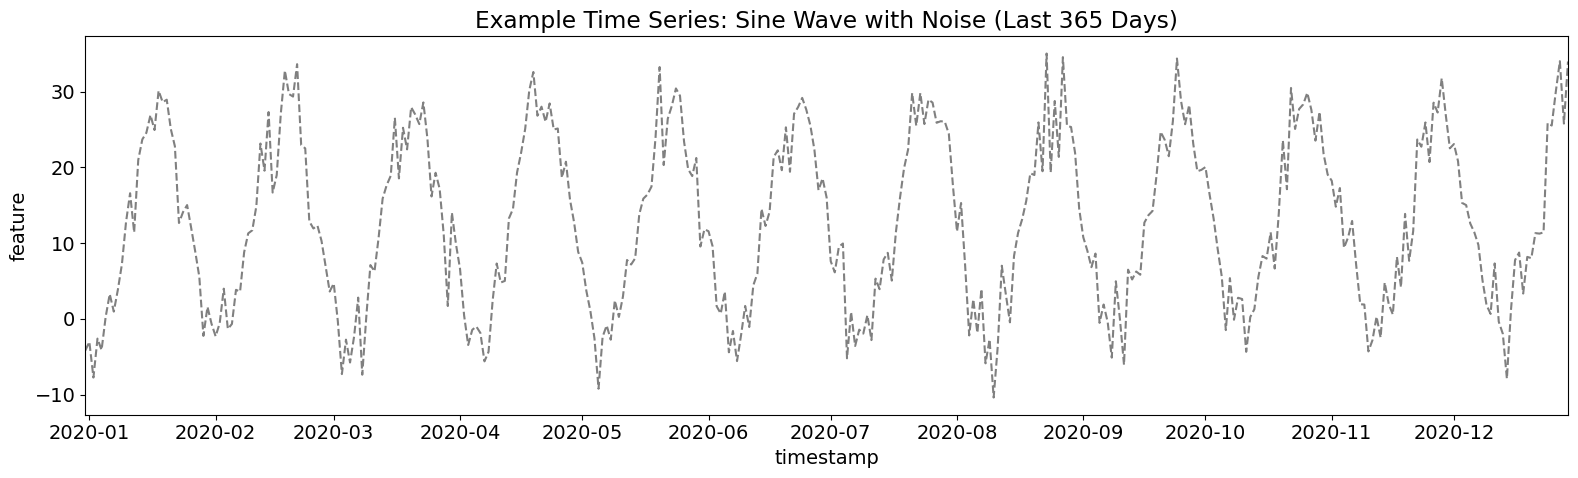

In [38]:
np.random.seed(SEED)

### Build fictional time series for experimenting ###
df_noise = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods = len(time), freq='D'),
                   'feature' : 15*np.sin(0.2*time+10)+13 + np.random.randint(-10, 10, len(time))*np.random.rand(len(time)),
                  })

# Create timestamps and set as index
df_noise.set_index('timestamp', inplace=True)

plot_example_time_series(df_noise[-365:], title = 'Example Time Series: Sine Wave with Noise (Last 365 Days)')

Ideally, we would hope that our model would generalize to fit the sine wave and not overfit to the added noise. With our example baseline model with `units = 100`, you can see that the model is not generalizing very well and that we need some sort of regularization.

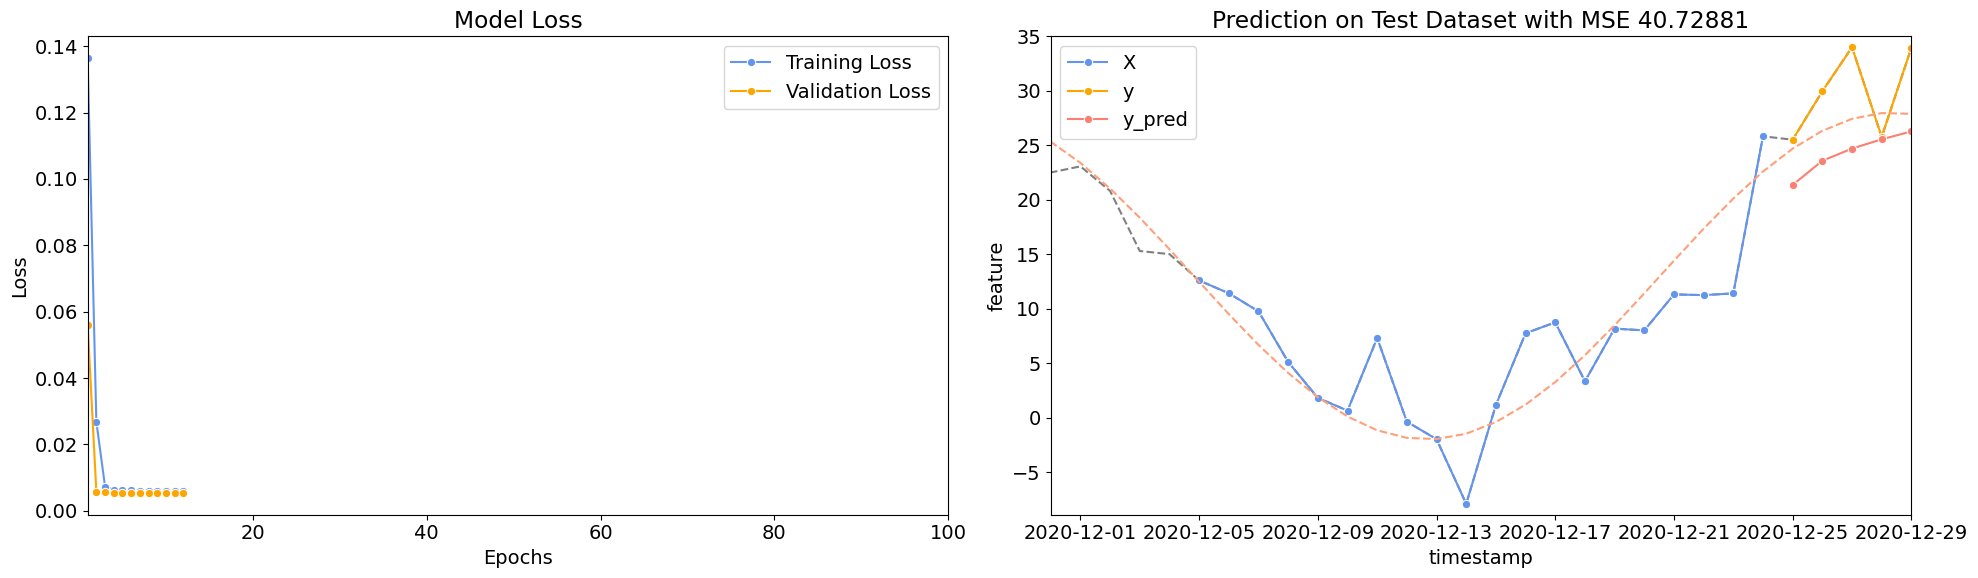

In [39]:
model = baseline_model(100)
_, ax = normalize_and_evaluate_baseline(model, df_noise)
sns.lineplot(x=df_noise.index, y=15*np.sin(0.2*time+10)+13, ax=ax[1], color = 'lightsalmon', linestyle='dashed')
plt.show()

📌 **Add dropout for regularization:** One idea to improve regularization is to add dropout to our model. You can set a value for the parameter`recurrent_dropout`. Alternatively, you could add a `Dropout` layer.

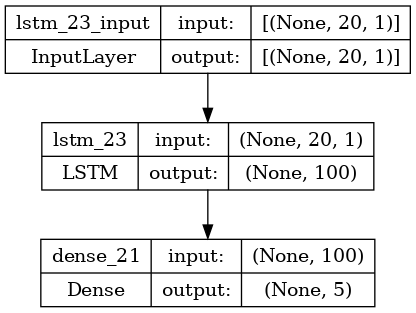

In [40]:
def model_with_dropout(lstm_units): 
    # Use initializers to initialize model parameters with the same values
    INITIALIZER_GLOROT_UNIFORM = tf.keras.initializers.GlorotUniform(seed = SEED)
    INITIALIZER_ORTHOGONAL = tf.keras.initializers.Orthogonal(gain = 1.0, seed = SEED)

    model = Sequential()
    model.add(LSTM(units                 = lstm_units, 
                   input_shape           = (N_STEPS_IN, N_FEATURES), 
                   activation            = 'relu',
                   kernel_initializer    = INITIALIZER_GLOROT_UNIFORM, 
                   recurrent_initializer = INITIALIZER_ORTHOGONAL,
    ##########################################################################
    # NEWLY ADDED
    ##########################################################################
                   recurrent_dropout     = 0.2,))
    ##########################################################################
    model.add(Dense(units              = N_STEPS_OUT,
                    kernel_initializer = INITIALIZER_GLOROT_UNIFORM))
    return model

# Create model instance
model = model_with_dropout(100)

# Visualize model architecture
display(keras.utils.plot_model(model, show_shapes=True))

The model with `recurrent_dropout = 0.2` is generalizing better to the sine wave as the model without it.

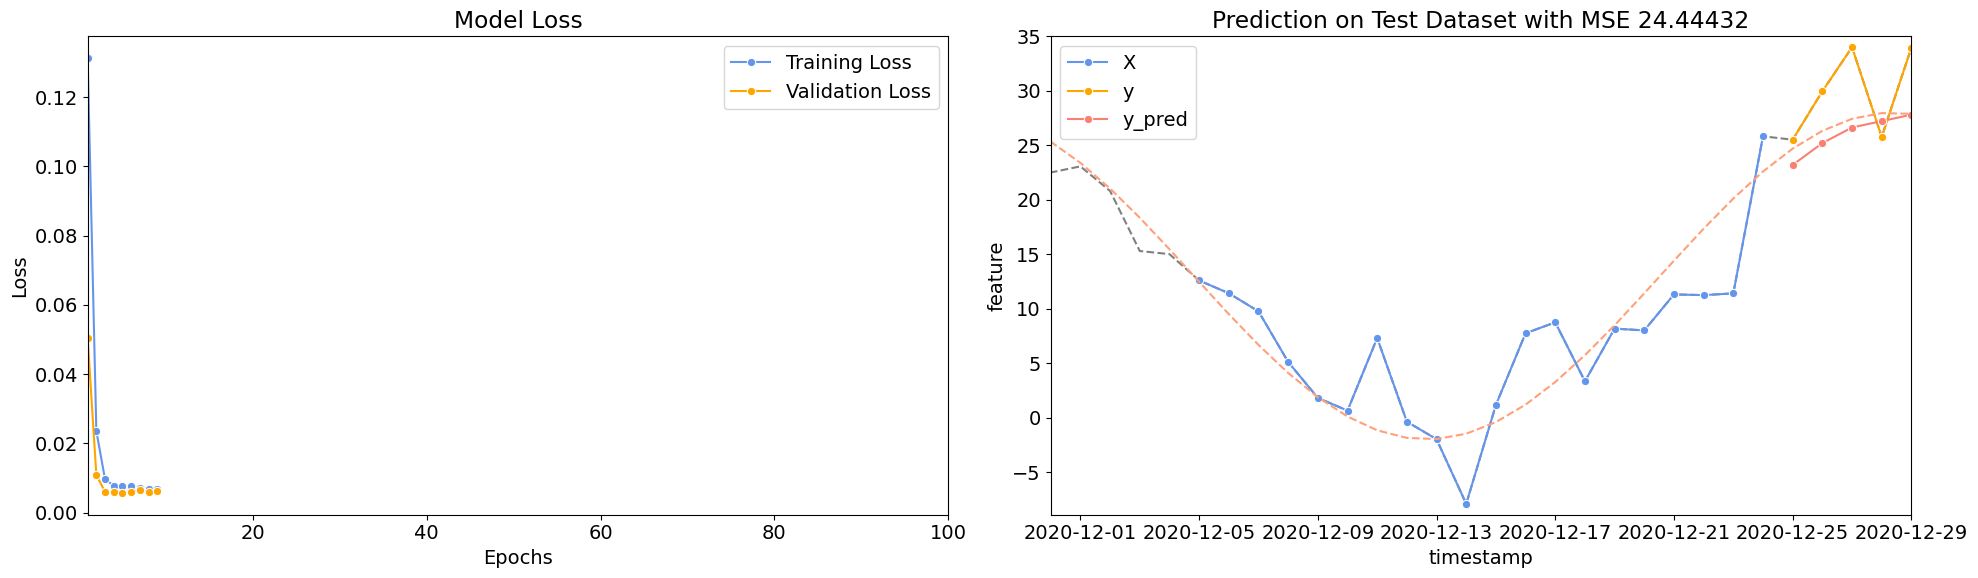

In [41]:
model = model_with_dropout(100)
_, ax = normalize_and_evaluate_baseline(model, df_noise)
sns.lineplot(x=df_noise.index, y=15*np.sin(0.2*time+10)+13, ax=ax[1], color = 'lightsalmon', linestyle='dashed')
plt.show()

# Adding Time Awareness

Let's have a look at another simple example: The square wave.

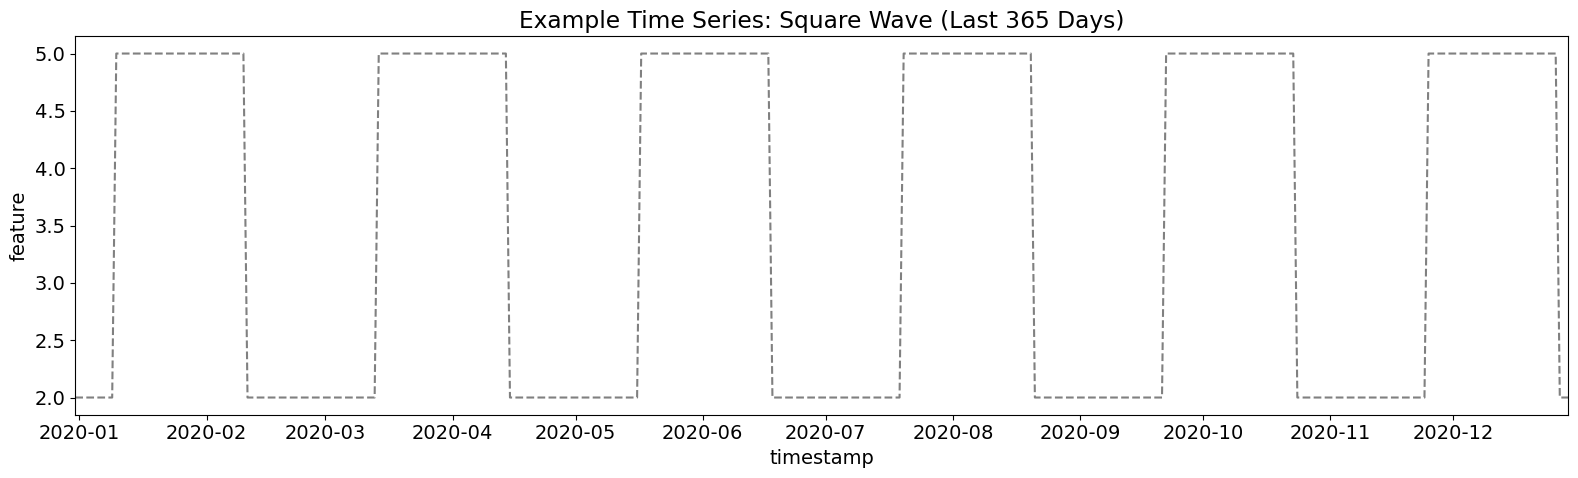

In [42]:
x = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ]
high = 5
low = 2
value = high
width = 32
for i in time[:-len(x)]:
    if i % width == 0:
        if value == high:
            value = low
        else:
            value = high
    x.append(value)

### Build fictional time series for experimenting ###
df_square = pd.DataFrame({'timestamp' : pd.date_range('2015-01-01', periods = len(time), freq='D'),
                   'feature' : x
                  })

# Create timestamps and set as index
df_square.set_index('timestamp', inplace=True)

plot_example_time_series(df_square[-365:], title = 'Example Time Series: Square Wave (Last 365 Days)')


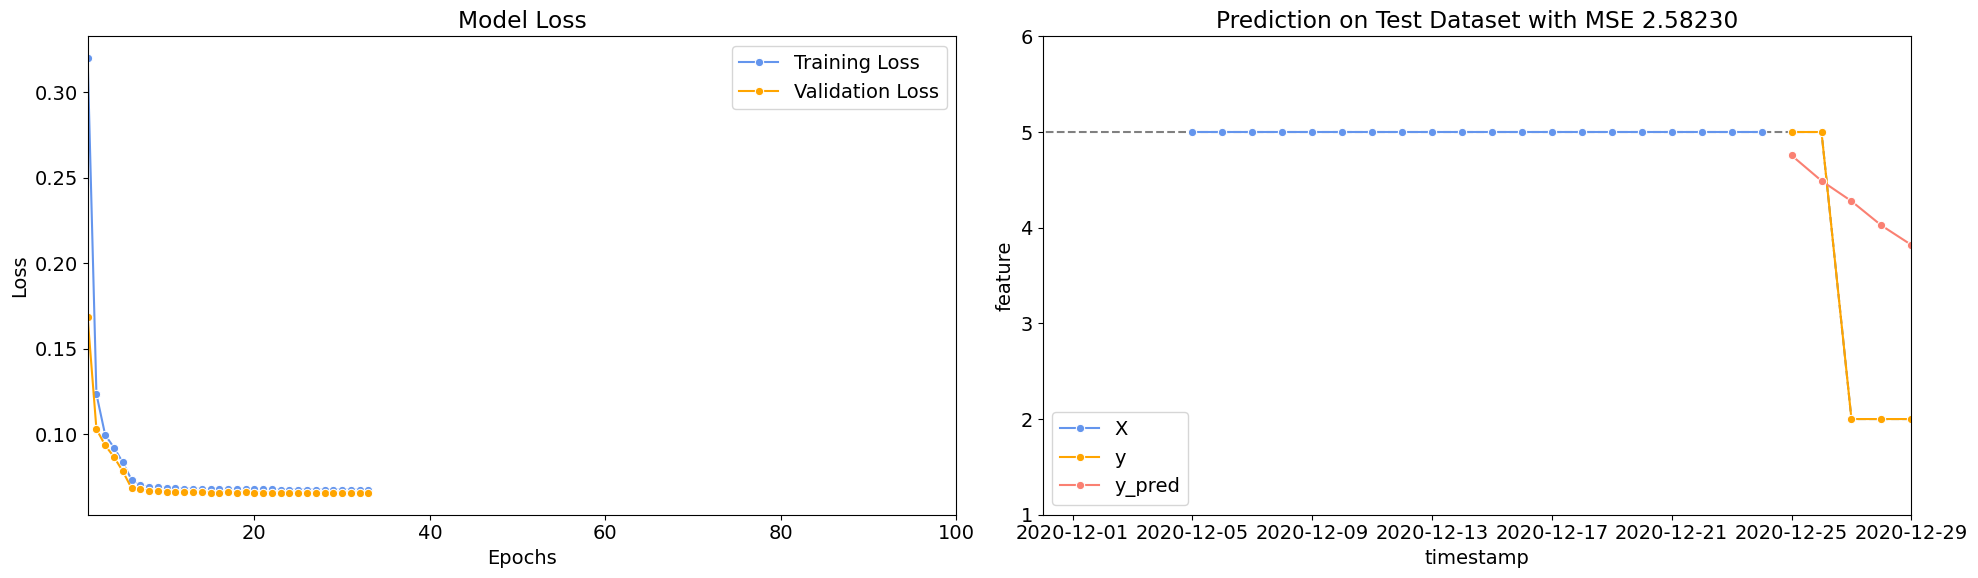

In [43]:
model = baseline_model(32)
_, _ = normalize_and_evaluate_baseline(model, df_square)

As you can see, with this simple square wave time series, if the period T is greater than `N_STEPS_IN`,  there is no way for the neural network to know "where" in the time series it is. 

One option to handle this would be to increase the value for `N_STEPS_IN`, so that the model knows where the last jump was. However, increasing `N_STEPS_IN` reduces the number of training samples as shown in below figure. And a reduced number of training samples can lead to lower performance.

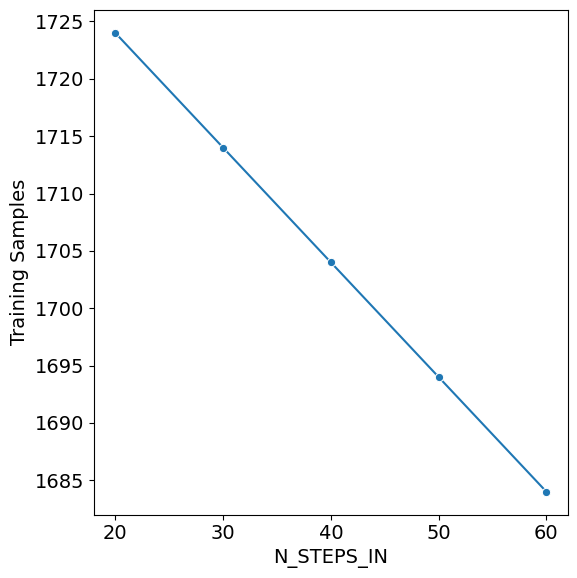

In [44]:
input_steps = [20, 30, 40, 50, 60]

training_samples = []
for steps in input_steps:
    time_series_dataset = MultiStepTimeSeriesGenerator(input_width = steps, 
                                          label_width = N_STEPS_OUT, 
                                          shift       = 1, 
                                          df          = df_square, 
                                          batch_size  = BATCH_SIZE)

    dataset = list(time_series_dataset.train.as_numpy_iterator())
    samples = 0
    for batch in range(len(dataset)):
        samples = samples + len(dataset[batch][0])
    training_samples.append(samples)
    
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.lineplot(x=input_steps, y=training_samples, marker = 'o')
ax.set_xlabel('N_STEPS_IN')
ax.set_ylabel('Training Samples')
plt.tight_layout()
plt.show()

Another option would be to add some time awareness to the input sequence in the form of a modulo signal. This would change the time series problem from a univariate time series problem to a **multivariate time series problem** where the input sequence consists of two inputs but there is only one output sequence to predict.

The new input signal should be a modulo signal with respect to the period T of the original `feature`. To find `T`, we can use ACF and PACF. If you need a refresher on ACF and PACF, you can have a look at this notebook: [Time Series: Interpreting ACF and PACF](https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf).

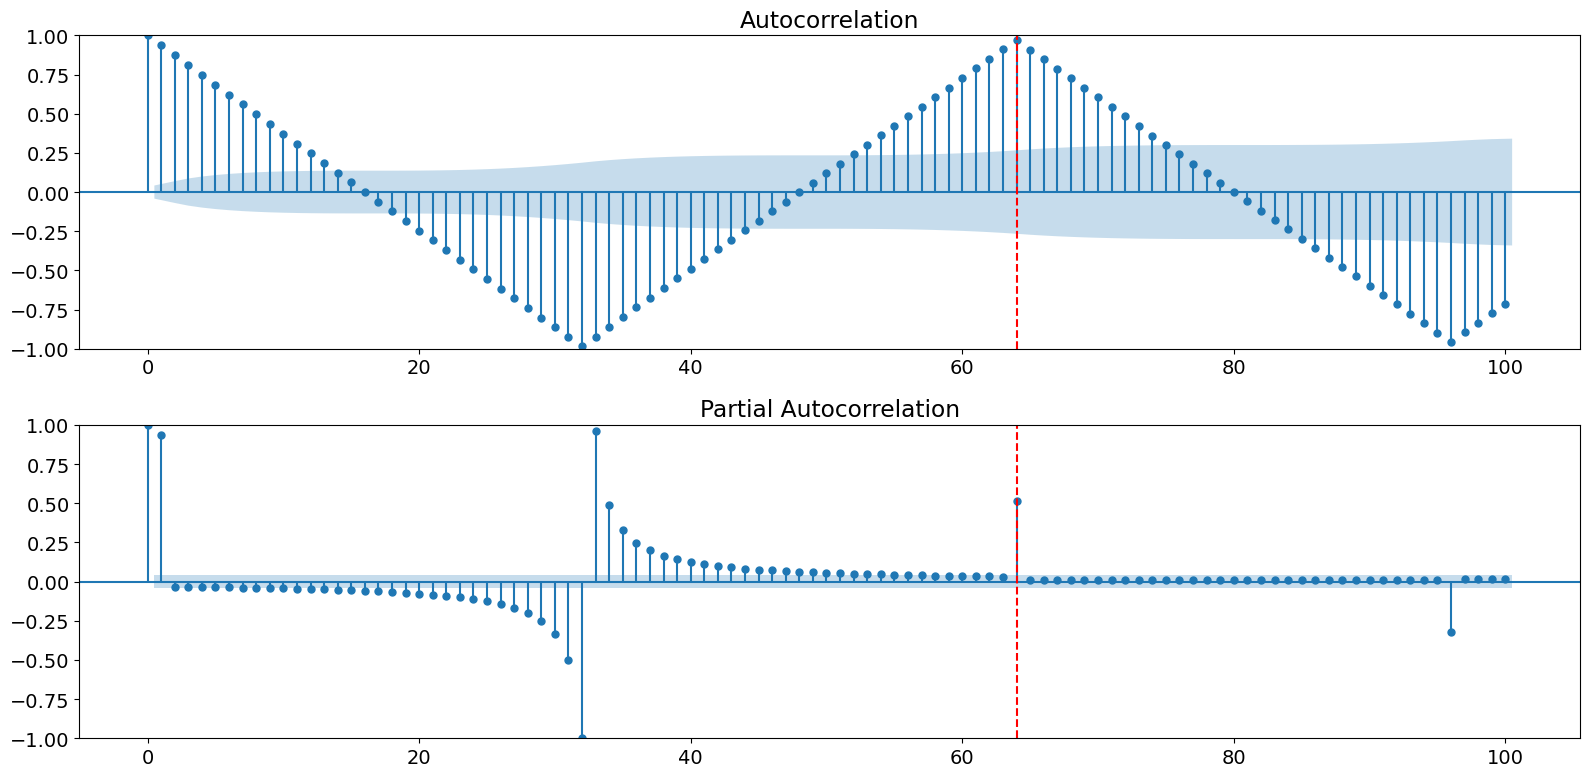

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(df_square['feature'],lags=100, ax=ax[0])
plot_pacf(df_square['feature'],lags=100, ax=ax[1], method='ols')
             
for i in range(2):
    ax[i].axvline(x=64, color='r', linestyle='--')
plt.tight_layout()
plt.show()

From the ACF and PACF plots, we can see that T = 64. We will create the new input signal `modulo_T` and change the number of input sequences to `N_FEATURES = 2`.

In [46]:
T                     = 64
df_square['modulo_T'] = time % T

N_FEATURES            = 2

In [47]:
df_square.head(5)

,feature,modulo_T
timestamp,,
2015-01-01,5,0
2015-01-02,5,1
2015-01-03,5,2
2015-01-04,5,3
2015-01-05,5,4


With this simple trick, the neural network can make much better predictions.

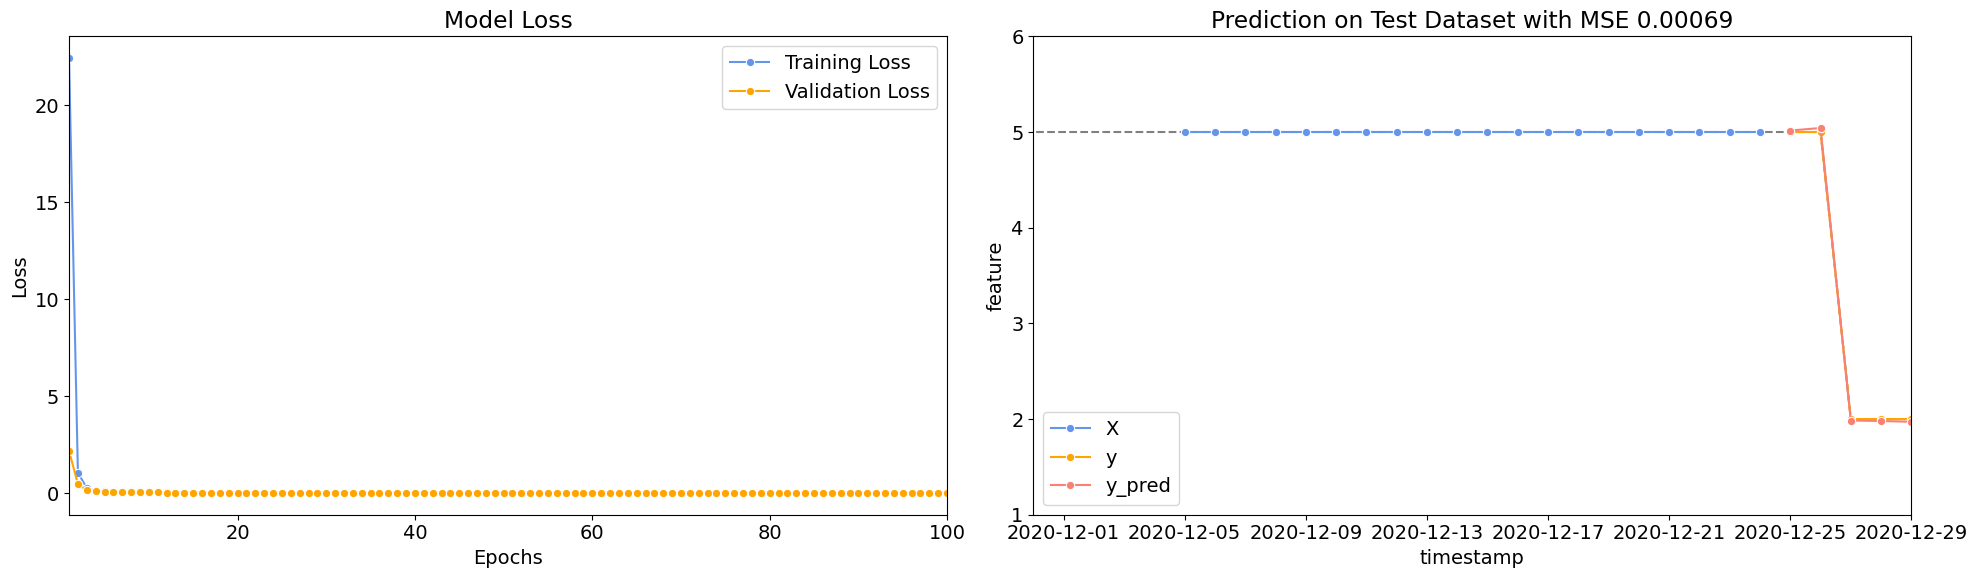

In [48]:
model = baseline_model(32)
_, _ = normalize_and_evaluate_baseline(model, df_square)

# Summary

## General Tips when working with Neural Networks

📌 Fix random seed

📌 Increase amount of data

📌 Increase number of epochs

📌 Decide on batch size

📌 Use Differencing to Remove Trend

📌 Apply Feature Transformations: Normalization or Standardization


## Tips for LSTMs

📌 Add kernel initializers to layers with fixed random seed

📌 Adjust Model Architecture: Increase LSTM units (increase width)

📌 Adjust Model Architecture: Stack LSTM layers (increase depth)

📌 Add dropout for regularization

📌 Add time awareness by adding modulo features


**If you have any further tips for training LSTMs, please feel free to leave them in the comments.**